# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 60     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle   = 0  # probability of batch-level sentence shuffle
    p_translate = 0  # probability of swapping a sentence with backtranslation
    noise_alpha = 0  # SD-adjusted noise magnitude in the targe values
    
    # architecture
    backbone       = 'roberta-large'  # transformer backbone   
    hidden_size    = 1024             # size of the hidden layer
    pretrained     = True             # pretrained weights [False, True, path]
    freeze_embed   = True             # whether to freeze the embedding layer
    freeze_layers  = 0                # how many deep transformer layers to freeze
    init_range     = None             # weight init range for new layers (None or float)
    hidden_dropout = 0.0              # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 4       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.95  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']

    # stochastic weight averaging
    swa               = False     
    swa_start         = 5
    swa_learning_rate = 1e-4
    anneal_epochs     = 3 
    anneal_strategy   = 'cos'
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 20    # no. cases per batch 

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle
import ipdb

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'you-api-token',
                 project_qualified_name = 'your-project')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-476


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')       # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 322
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [10]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.2560 vs 0.1142 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
0, 250, 5973, 2060, 1023, 3760, 21, 1613, 6, 29396, 21, 1613, 4, 20, 929    |           -3.081337118
0, 243, 21, 2047, 30, 5, 5402, 604, 9, 2240, 14, 7765, 12749, 18, 19023     |           -2.145248365
0, 133, 6700, 11, 10, 3027, 2352, 2322, 5, 1946, 9, 80, 4, 20, 32           |           -1.400318025
0, 133, 31918, 3203, 40968, 62, 8, 159, 5, 251, 6, 614, 12, 1755, 6691      |           -0.495298635
0, 713, 10829, 338, 1512, 281, 21, 39676, 12, 7109, 107, 793, 4, 91, 21     |            0.245805709
----------------------------------------------------------------------------------------------------
<s>It was believed by the principal men of Virginia that Talbot's sympath   |           -3.081337118
<s>This Pedrarias was seventy-two years old. He was     

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6805 | val_loss = 0.2823 | val_score = 0.5313 | 6.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2007 | val_loss = 0.2526 | val_score = 0.5026 | 4.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0776 | val_loss = 0.2416 | val_score = 0.4915 | 4.37 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0233 | val_loss = 0.2369 | val_score = 0.4868 | 3.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0097 | val_loss = 0.2401 | val_score = 0.4900 | 3.02 min
-------------------------------------------------------
Best: score = 0.4868 (epoch 4)
-------------------------------------------------------


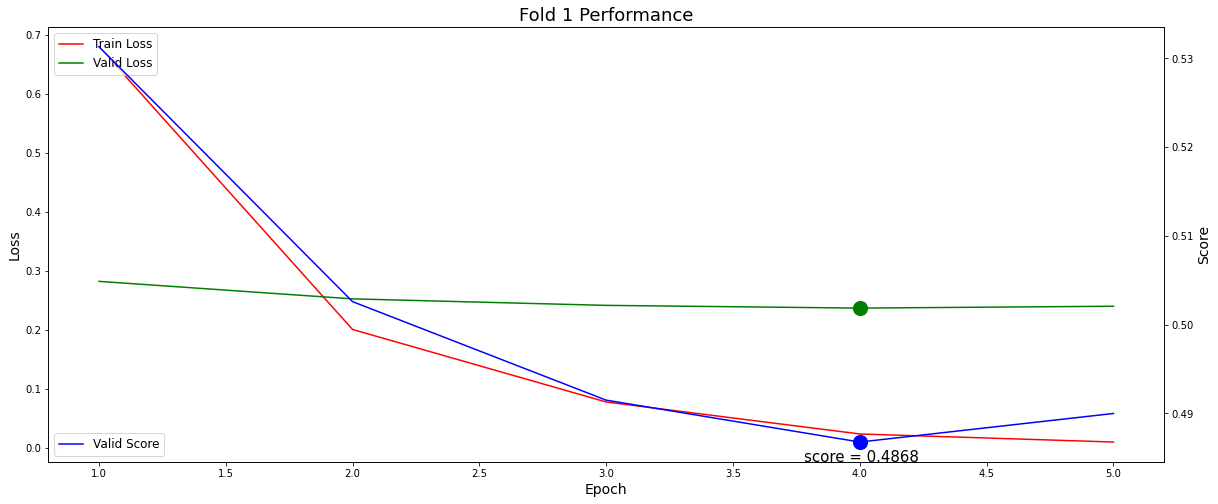

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.0344 | val_loss = 0.3368 | val_score = 0.5804 | 5.15 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2977 | val_loss = 0.2643 | val_score = 0.5141 | 4.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1388 | val_loss = 0.2276 | val_score = 0.4771 | 4.66 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0465 | val_loss = 0.2290 | val_score = 0.4785 | 3.04 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0206 | val_loss = 0.2303 | val_score = 0.4799 | 3.04 min
-------------------------------------------------------
Best: score = 0.4771 (epoch 3)
-------------------------------------------------------


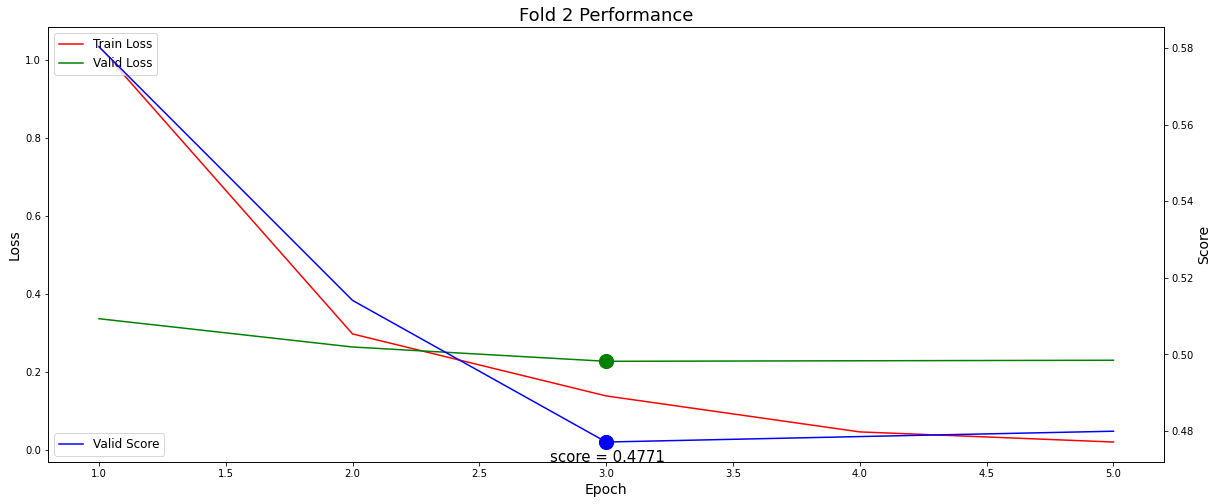

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5903 | val_loss = 0.3205 | val_score = 0.5661 | 5.16 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2221 | val_loss = 0.2463 | val_score = 0.4963 | 4.29 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0751 | val_loss = 0.2271 | val_score = 0.4765 | 4.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0231 | val_loss = 0.2291 | val_score = 0.4787 | 3.04 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0096 | val_loss = 0.2312 | val_score = 0.4808 | 3.04 min
-------------------------------------------------------
Best: score = 0.4765 (epoch 3)
-------------------------------------------------------


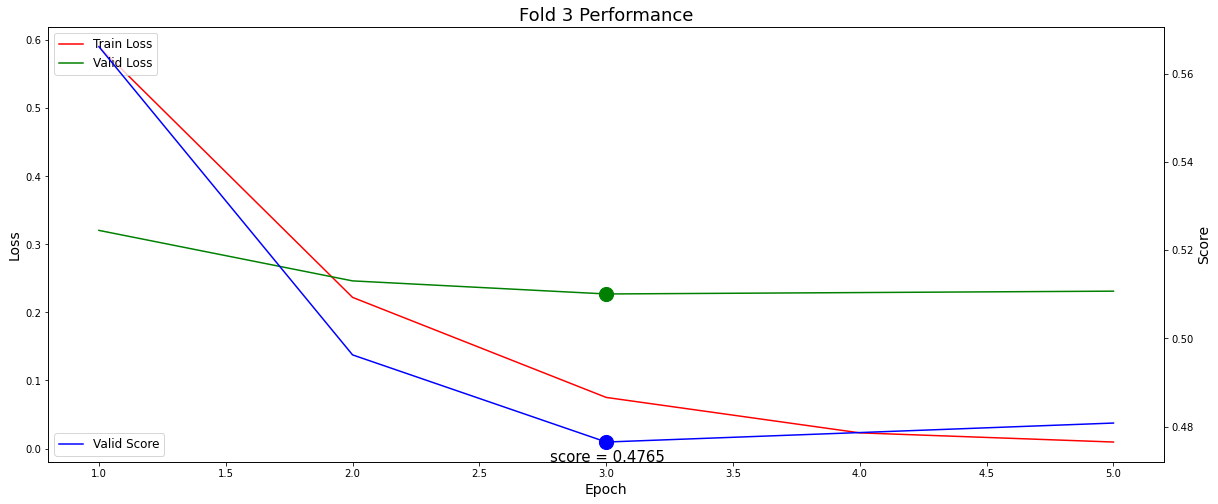

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5987 | val_loss = 0.2987 | val_score = 0.5465 | 5.39 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2235 | val_loss = 0.2418 | val_score = 0.4917 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0975 | val_loss = 0.2402 | val_score = 0.4901 | 3.52 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0328 | val_loss = 0.2375 | val_score = 0.4873 | 3.59 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0128 | val_loss = 0.2403 | val_score = 0.4902 | 3.04 min
-------------------------------------------------------
Best: score = 0.4873 (epoch 4)
-------------------------------------------------------


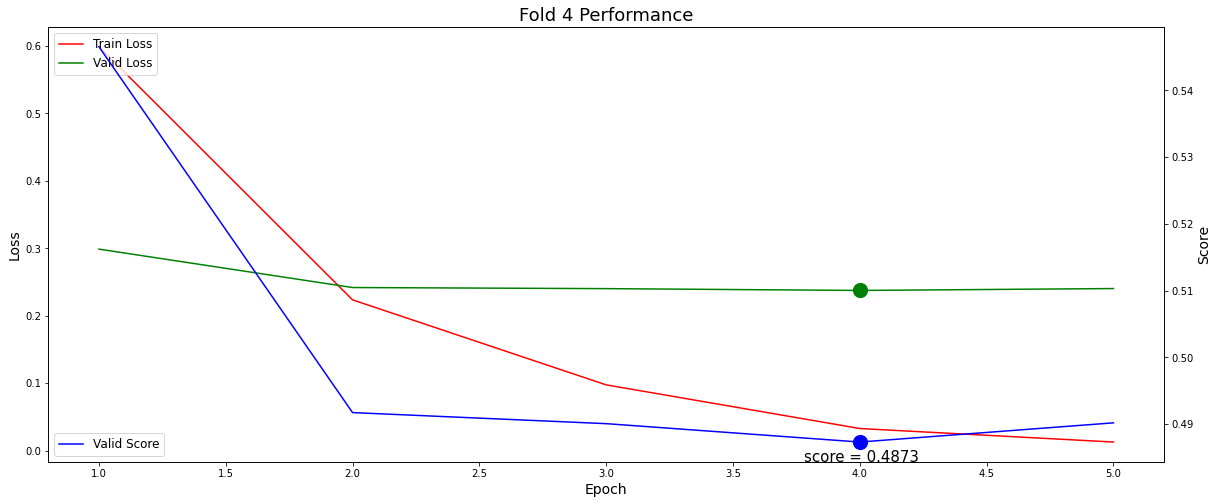

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5792 | val_loss = 0.3127 | val_score = 0.5592 | 5.95 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2211 | val_loss = 0.2559 | val_score = 0.5059 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1060 | val_loss = 0.2457 | val_score = 0.4957 | 3.90 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0392 | val_loss = 0.2333 | val_score = 0.4830 | 4.30 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0176 | val_loss = 0.2353 | val_score = 0.4850 | 3.04 min
-------------------------------------------------------
Best: score = 0.4830 (epoch 4)
-------------------------------------------------------


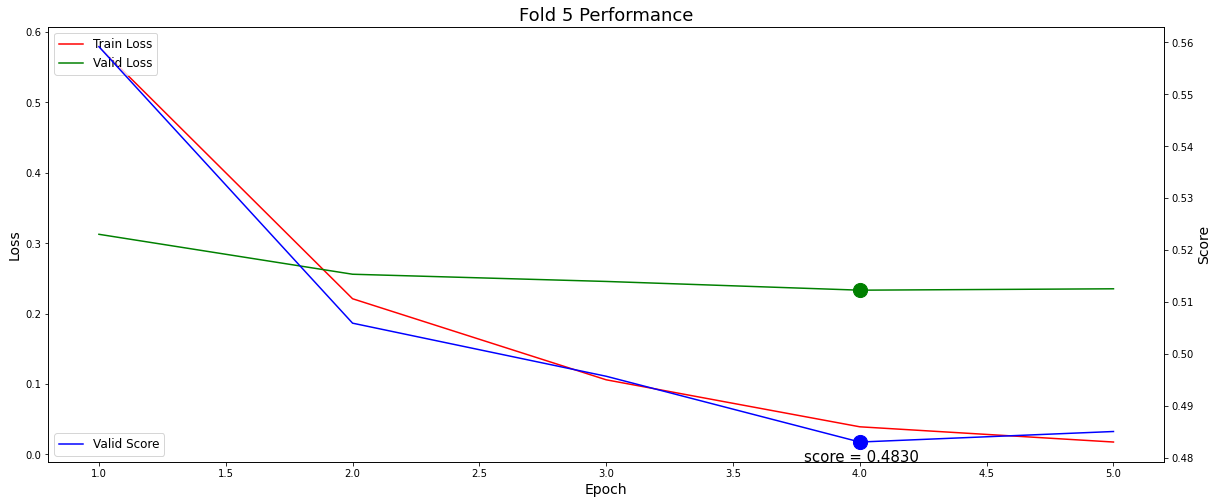

-------------------------------------------------------
REP 1/3 | OOF score = 0.4821
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6586 | val_loss = 0.3141 | val_score = 0.5604 | 4.55 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2397 | val_loss = 0.2603 | val_score = 0.5102 | 4.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1101 | val_loss = 0.2289 | val_score = 0.4784 | 4.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0292 | val_loss = 0.2295 | val_score = 0.4790 | 3.05 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0127 | val_loss = 0.2309 | val_score = 0.4805 | 3.04 min
-------------------------------------------------------
Best: score = 0.4784 (epoch 3)
-------------------------------------------------------


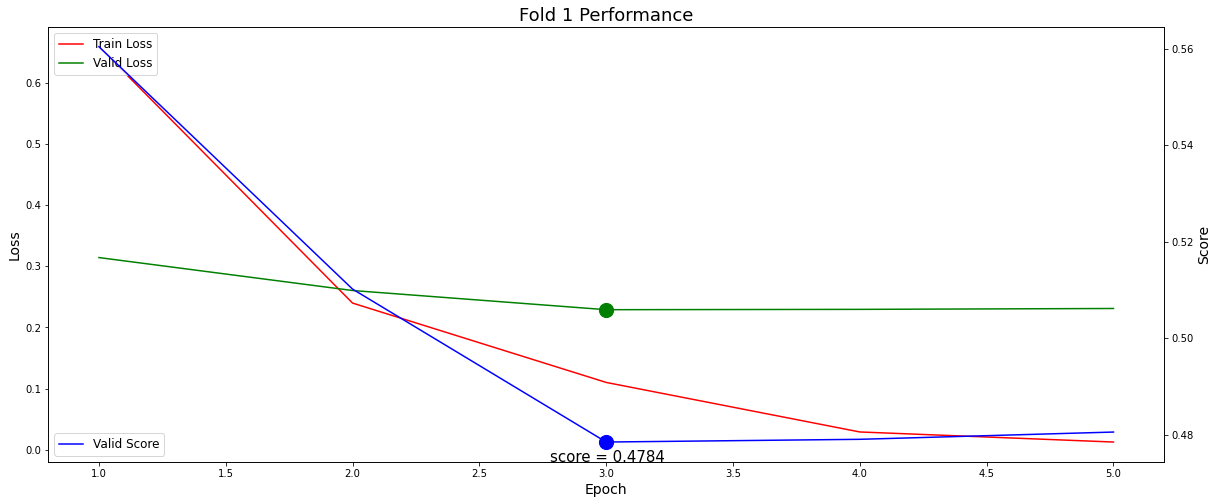

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.1469 | val_loss = 0.3150 | val_score = 0.5612 | 4.94 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2671 | val_loss = 0.2666 | val_score = 0.5163 | 4.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0998 | val_loss = 0.2466 | val_score = 0.4966 | 4.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0349 | val_loss = 0.2427 | val_score = 0.4927 | 4.80 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0126 | val_loss = 0.2428 | val_score = 0.4927 | 3.05 min
-------------------------------------------------------
Best: score = 0.4927 (epoch 4)
-------------------------------------------------------


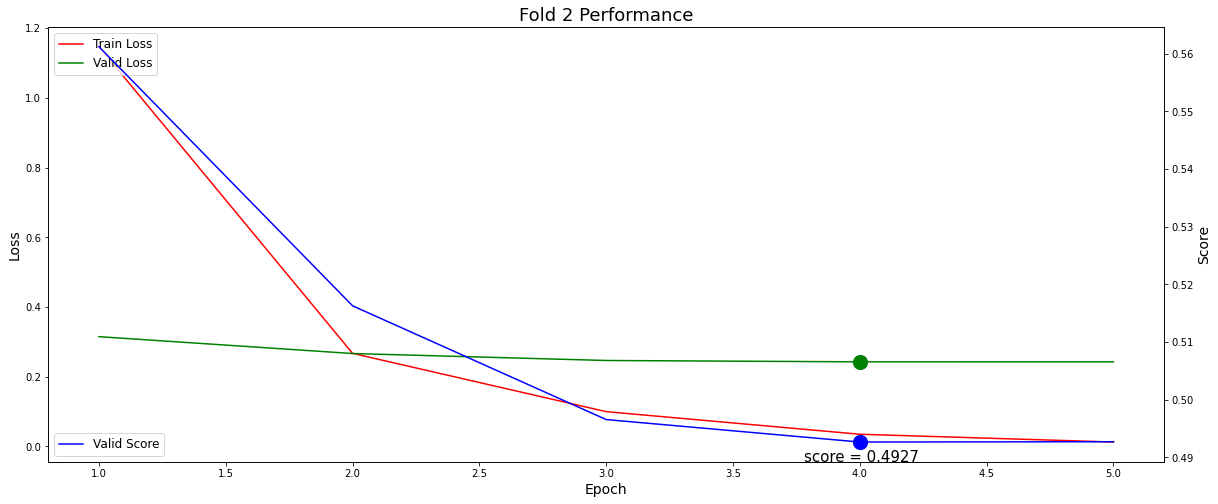

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5538 | val_loss = 0.2985 | val_score = 0.5464 | 6.06 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2049 | val_loss = 0.2542 | val_score = 0.5042 | 4.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0709 | val_loss = 0.2270 | val_score = 0.4764 | 4.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0218 | val_loss = 0.2306 | val_score = 0.4802 | 3.05 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0084 | val_loss = 0.2323 | val_score = 0.4820 | 3.04 min
-------------------------------------------------------
Best: score = 0.4764 (epoch 3)
-------------------------------------------------------


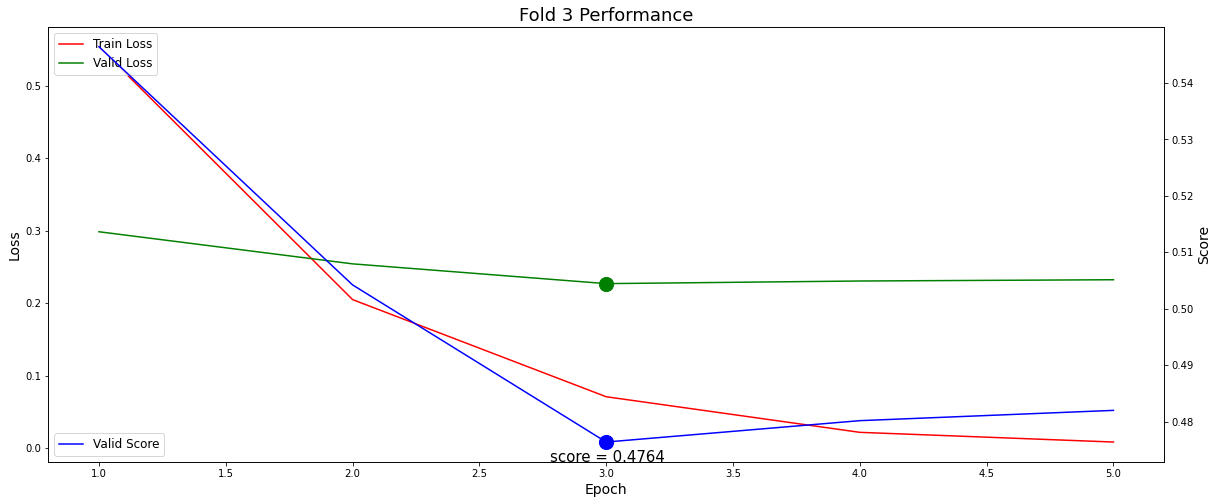

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5753 | val_loss = 0.2989 | val_score = 0.5467 | 5.51 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2296 | val_loss = 0.2513 | val_score = 0.5013 | 5.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0882 | val_loss = 0.2370 | val_score = 0.4868 | 4.19 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0305 | val_loss = 0.2299 | val_score = 0.4795 | 3.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0127 | val_loss = 0.2345 | val_score = 0.4842 | 3.07 min
-------------------------------------------------------
Best: score = 0.4795 (epoch 4)
-------------------------------------------------------


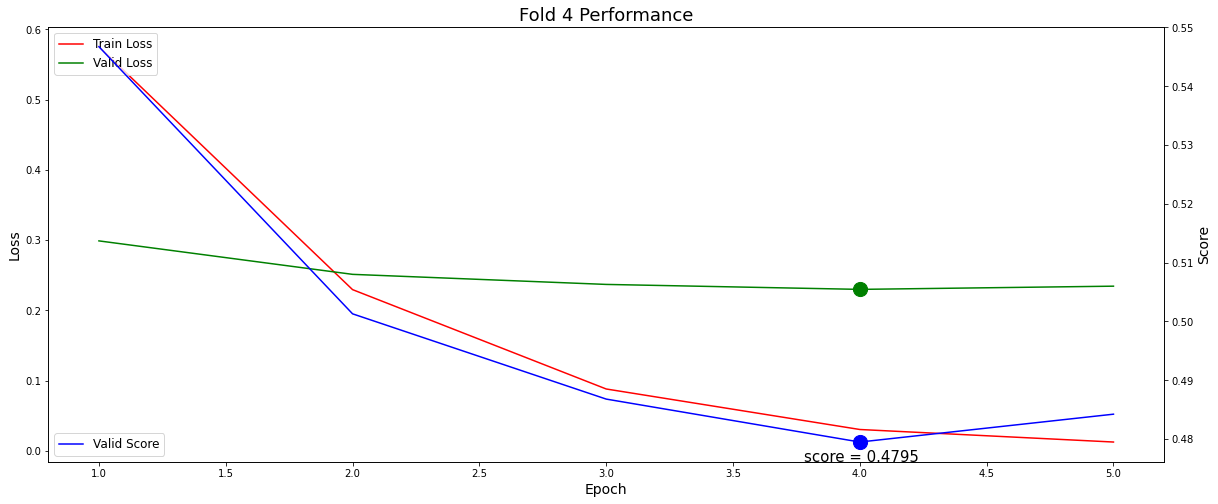

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5811 | val_loss = 0.2950 | val_score = 0.5431 | 5.84 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2787 | val_loss = 0.2430 | val_score = 0.4929 | 4.33 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0963 | val_loss = 0.2293 | val_score = 0.4788 | 3.38 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0294 | val_loss = 0.2272 | val_score = 0.4766 | 4.17 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0120 | val_loss = 0.2252 | val_score = 0.4746 | 3.57 min
-------------------------------------------------------
Best: score = 0.4746 (epoch 5)
-------------------------------------------------------


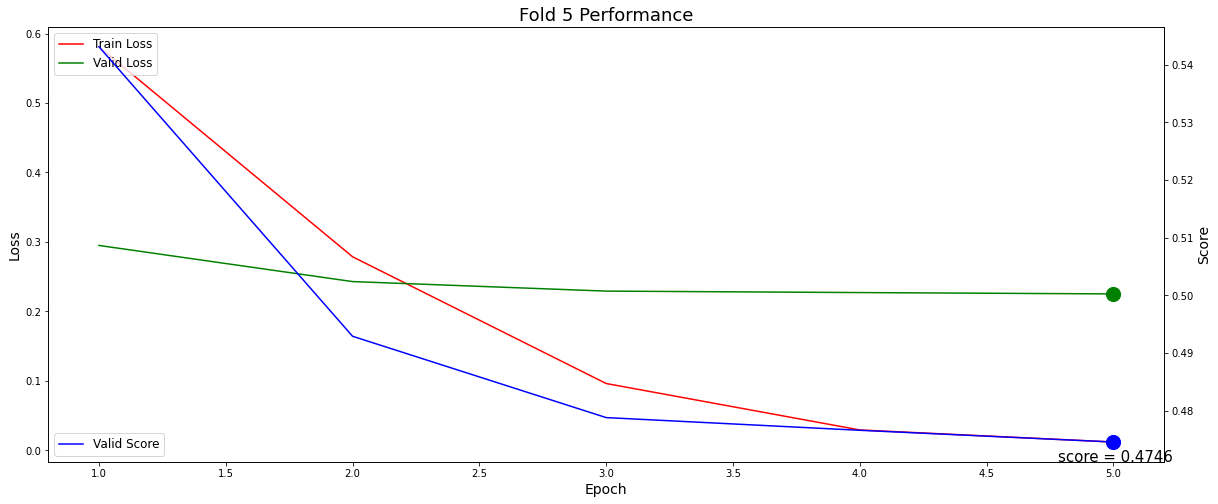

-------------------------------------------------------
REP 2/3 | OOF score = 0.4803
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6572 | val_loss = 0.3311 | val_score = 0.5754 | 5.51 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2373 | val_loss = 0.2369 | val_score = 0.4867 | 4.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0855 | val_loss = 0.2254 | val_score = 0.4748 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0235 | val_loss = 0.2221 | val_score = 0.4713 | 3.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0097 | val_loss = 0.2244 | val_score = 0.4737 | 3.07 min
-------------------------------------------------------
Best: score = 0.4713 (epoch 4)
-------------------------------------------------------


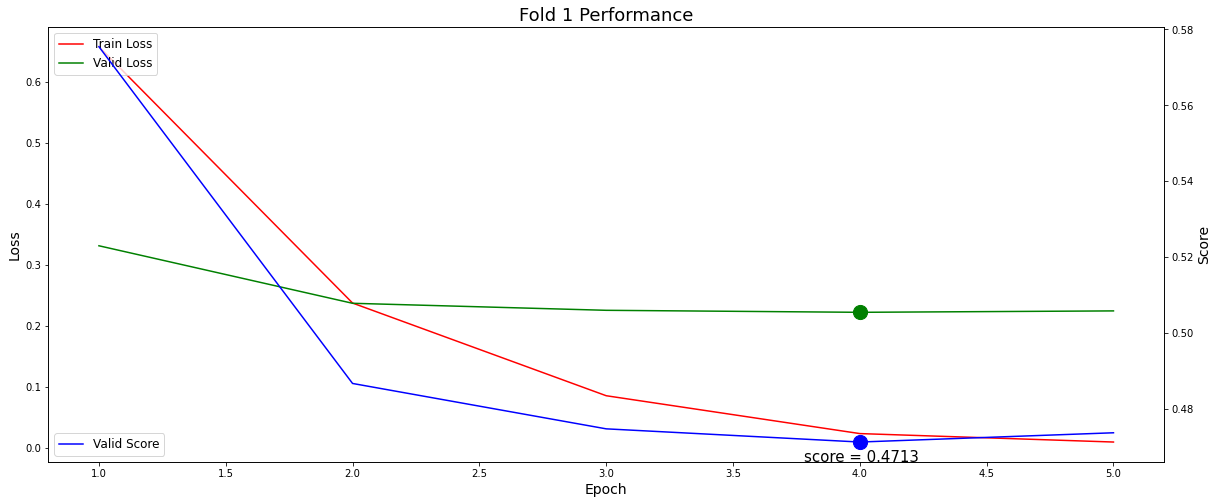

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.0611 | val_loss = 0.3088 | val_score = 0.5557 | 5.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2438 | val_loss = 0.2348 | val_score = 0.4846 | 4.26 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1058 | val_loss = 0.2254 | val_score = 0.4747 | 3.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0370 | val_loss = 0.2191 | val_score = 0.4681 | 3.91 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0152 | val_loss = 0.2208 | val_score = 0.4699 | 3.08 min
-------------------------------------------------------
Best: score = 0.4681 (epoch 4)
-------------------------------------------------------


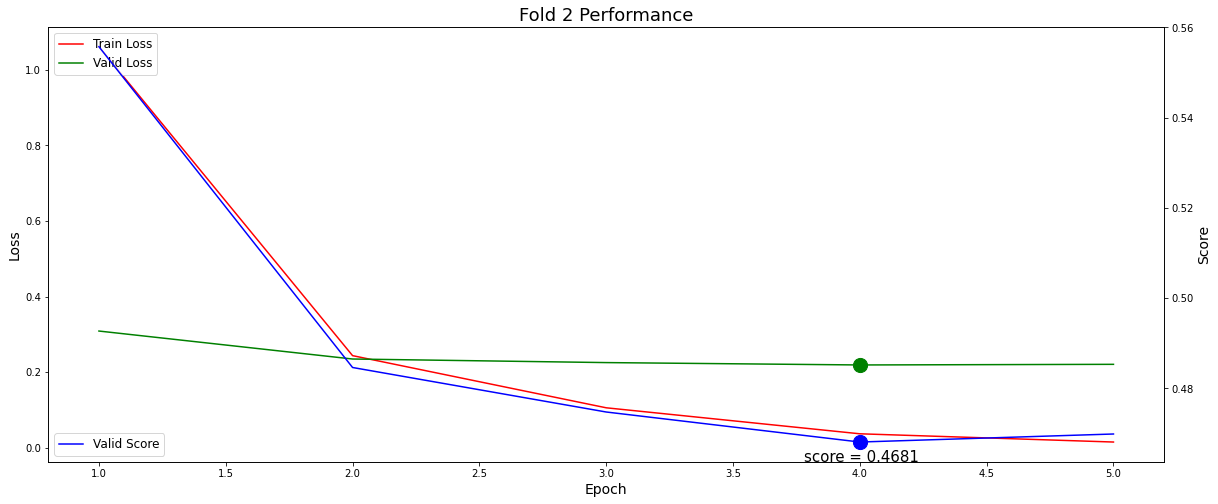

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5393 | val_loss = 0.2969 | val_score = 0.5449 | 4.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2332 | val_loss = 0.2360 | val_score = 0.4858 | 5.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0798 | val_loss = 0.2202 | val_score = 0.4692 | 3.85 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0246 | val_loss = 0.2225 | val_score = 0.4717 | 3.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0103 | val_loss = 0.2272 | val_score = 0.4766 | 3.07 min
-------------------------------------------------------
Best: score = 0.4692 (epoch 3)
-------------------------------------------------------


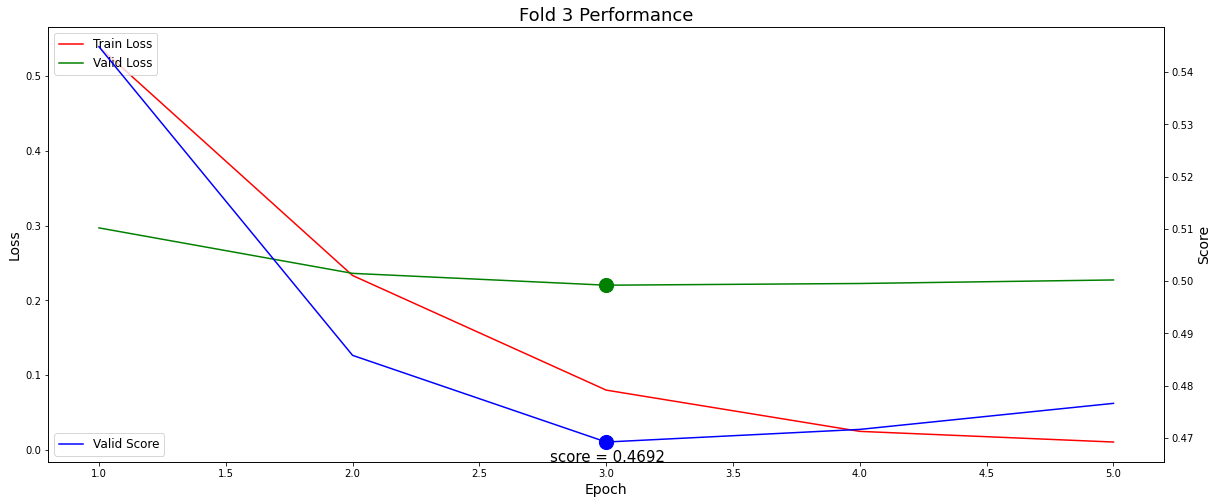

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6230 | val_loss = 0.3169 | val_score = 0.5629 | 5.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2633 | val_loss = 0.2421 | val_score = 0.4920 | 5.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0865 | val_loss = 0.2372 | val_score = 0.4870 | 3.40 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0268 | val_loss = 0.2391 | val_score = 0.4890 | 3.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0100 | val_loss = 0.2385 | val_score = 0.4884 | 3.08 min
-------------------------------------------------------
Best: score = 0.4870 (epoch 3)
-------------------------------------------------------


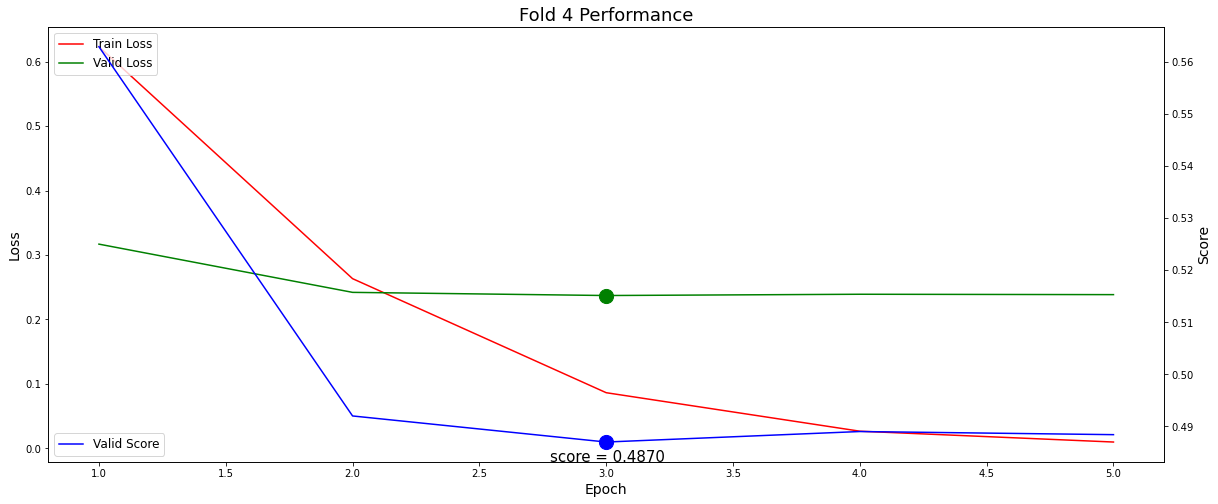

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5957 | val_loss = 0.3460 | val_score = 0.5882 | 5.42 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2340 | val_loss = 0.2499 | val_score = 0.4999 | 5.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0876 | val_loss = 0.2485 | val_score = 0.4985 | 3.32 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0308 | val_loss = 0.2399 | val_score = 0.4898 | 4.17 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0120 | val_loss = 0.2409 | val_score = 0.4909 | 3.08 min
-------------------------------------------------------
Best: score = 0.4898 (epoch 4)
-------------------------------------------------------


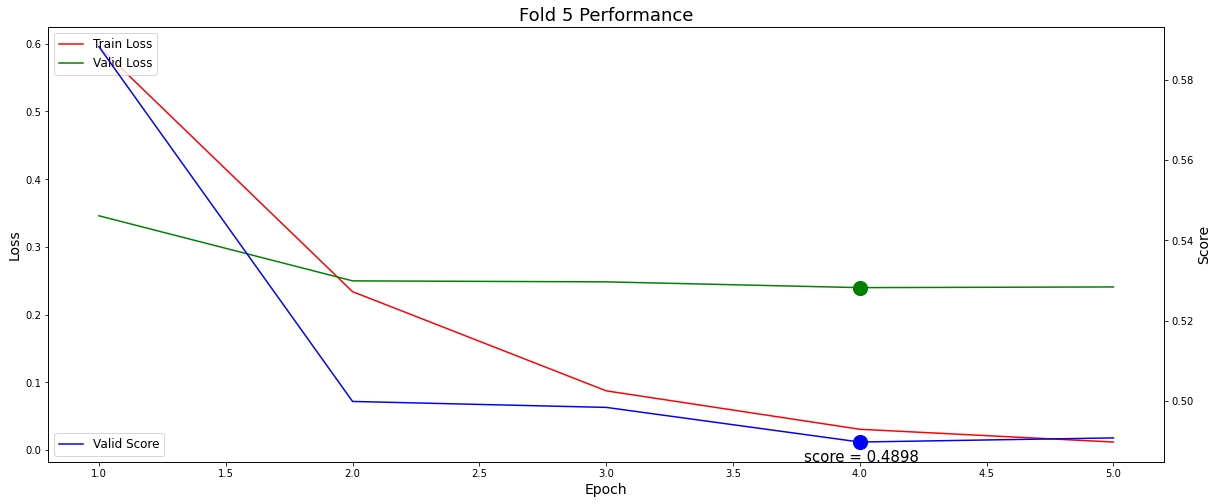

-------------------------------------------------------
REP 3/3 | OOF score = 0.4771
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4798
-------------------------------------------------------

Finished in 314.78 minutes


In [12]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [13]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 14.74 minutes


In [14]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4799
OOF bag score = 0.4711
----------------------


In [15]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()

# 1. PARAMETERS

In [16]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 61     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle     = 0    # probability of batch-level sentence shuffle
    p_translate = 0     # probability of swapping a sentence with backtranslation
    noise_alpha = 0     # SD-adjusted noise magnitude in the targe values
    
    # SWA
    swa = False
    
    # architecture
    backbone       = 'roberta-large'  # transformer backbone   
    hidden_size    = 1024             # size of the hidden layer
    pretrained     = True            # pretrained weights [False, True, path]
    freeze_embed   = True            # whether to freeze the embedding layer
    freeze_layers  = 0               # how many deep transformer layers to freeze
    init_range     = None            # weight init range for new layers (None or float)
    hidden_dropout = 0.0             # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 5       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.95  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 20    # no. cases per batch 

In [17]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [18]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [19]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle
import ipdb

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [20]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [21]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [22]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZjVlMTZiZS1kYjcyLTRmZmQtYjJhYS0xMmIyYzdiNzFkMzcifQ==',
                 project_qualified_name = 'ml_comps/readability')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-480


In [23]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [24]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 322
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [25]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [26]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.3268 vs 0.4556 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
0, 250, 5973, 2060, 1023, 3760, 21, 1613, 6, 29396, 21, 1613, 4, 20, 929    |           -3.081337118
0, 243, 21, 2047, 30, 5, 5402, 604, 9, 2240, 14, 7765, 12749, 18, 19023     |           -2.145248365
0, 133, 6700, 11, 10, 3027, 2352, 2322, 5, 1946, 9, 80, 4, 20, 32           |           -1.400318025
0, 133, 31918, 3203, 40968, 62, 8, 159, 5, 251, 6, 614, 12, 1755, 6691      |           -0.495298635
0, 713, 10829, 338, 1512, 281, 21, 39676, 12, 7109, 107, 793, 4, 91, 21     |            0.245805709
----------------------------------------------------------------------------------------------------
<s>It was believed by the principal men of Virginia that Talbot's sympath   |           -3.081337118
<s>This Pedrarias was seventy-two years old. He was     

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6511 | val_loss = 0.2656 | val_score = 0.5154 | 5.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2183 | val_loss = 0.2592 | val_score = 0.5091 | 3.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0808 | val_loss = 0.2344 | val_score = 0.4842 | 4.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0239 | val_loss = 0.2357 | val_score = 0.4855 | 3.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0097 | val_loss = 0.2356 | val_score = 0.4854 | 3.22 min
-------------------------------------------------------
Best: score = 0.4842 (epoch 3)
-------------------------------------------------------


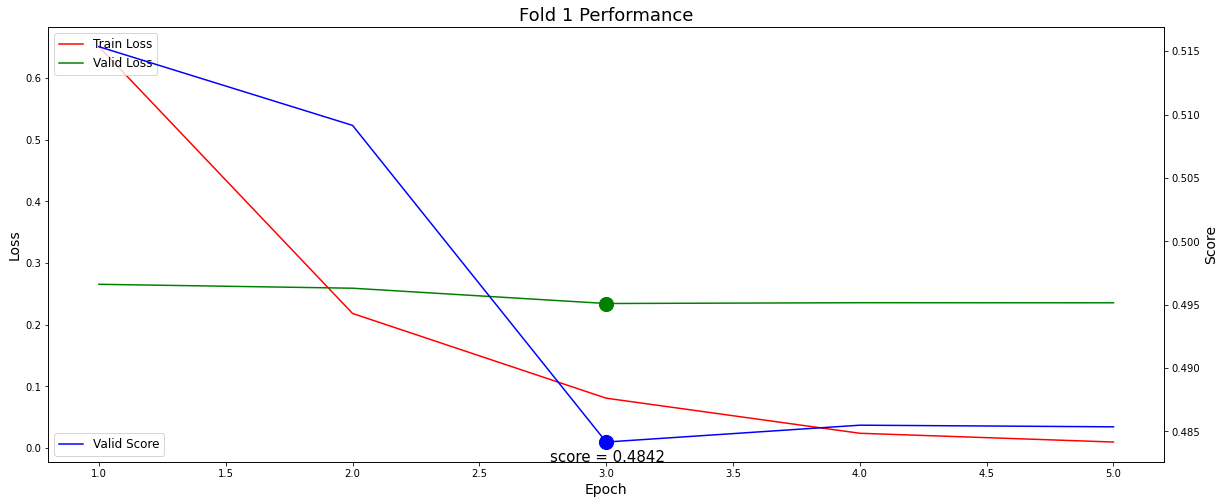

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.0462 | val_loss = 0.2943 | val_score = 0.5425 | 5.93 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2700 | val_loss = 0.2575 | val_score = 0.5074 | 4.36 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1064 | val_loss = 0.2308 | val_score = 0.4804 | 4.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0340 | val_loss = 0.2298 | val_score = 0.4793 | 4.06 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0139 | val_loss = 0.2314 | val_score = 0.4811 | 3.20 min
-------------------------------------------------------
Best: score = 0.4793 (epoch 4)
-------------------------------------------------------


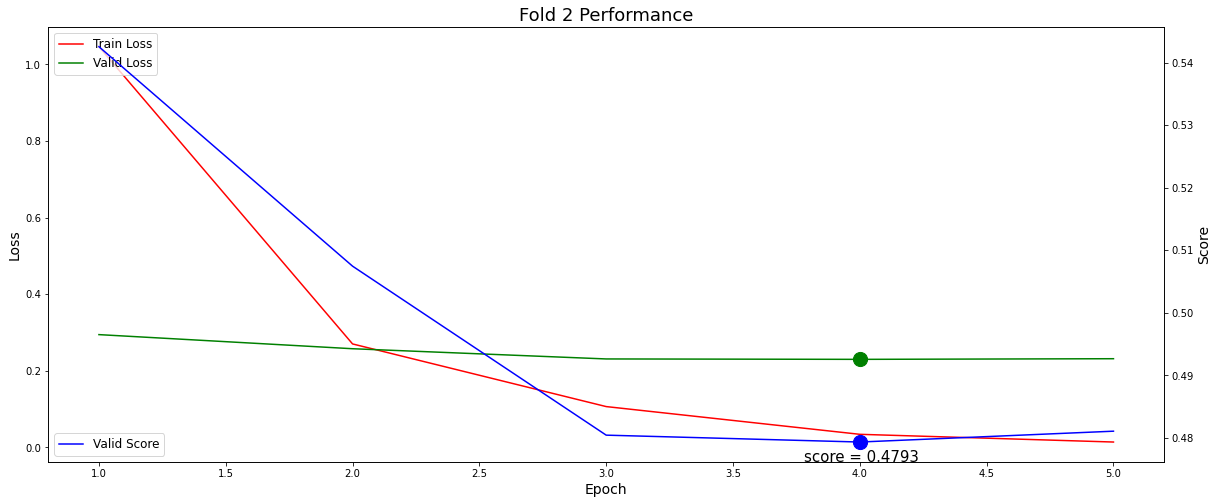

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6063 | val_loss = 0.3165 | val_score = 0.5626 | 5.38 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2454 | val_loss = 0.2422 | val_score = 0.4922 | 5.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0801 | val_loss = 0.2242 | val_score = 0.4735 | 3.93 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0232 | val_loss = 0.2226 | val_score = 0.4718 | 3.54 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0097 | val_loss = 0.2257 | val_score = 0.4751 | 3.21 min
-------------------------------------------------------
Best: score = 0.4718 (epoch 4)
-------------------------------------------------------


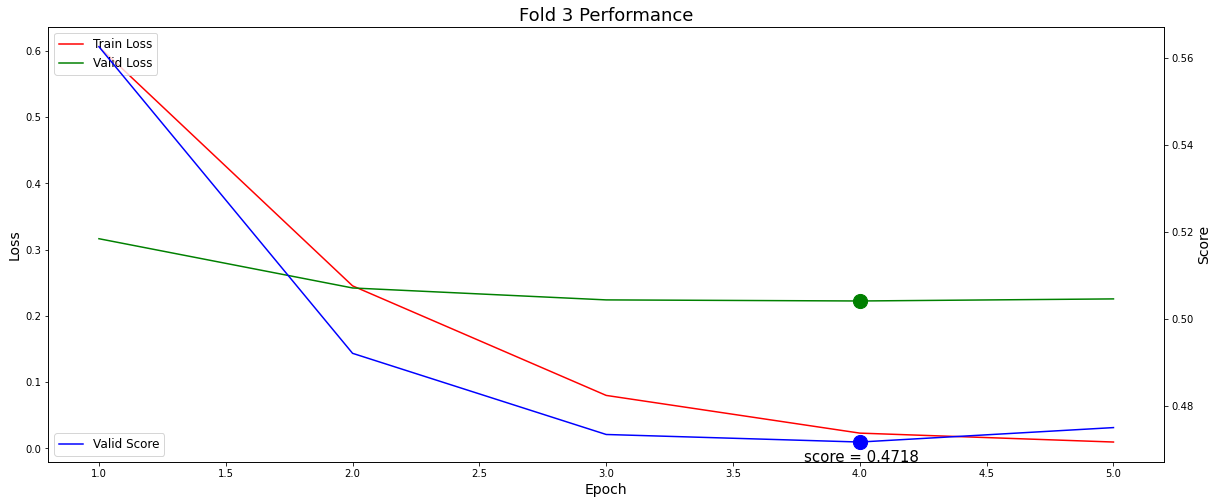

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6713 | val_loss = 0.3113 | val_score = 0.5580 | 5.23 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2247 | val_loss = 0.2537 | val_score = 0.5037 | 4.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0989 | val_loss = 0.2331 | val_score = 0.4829 | 4.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0375 | val_loss = 0.2325 | val_score = 0.4822 | 3.47 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0150 | val_loss = 0.2335 | val_score = 0.4832 | 3.22 min
-------------------------------------------------------
Best: score = 0.4822 (epoch 4)
-------------------------------------------------------


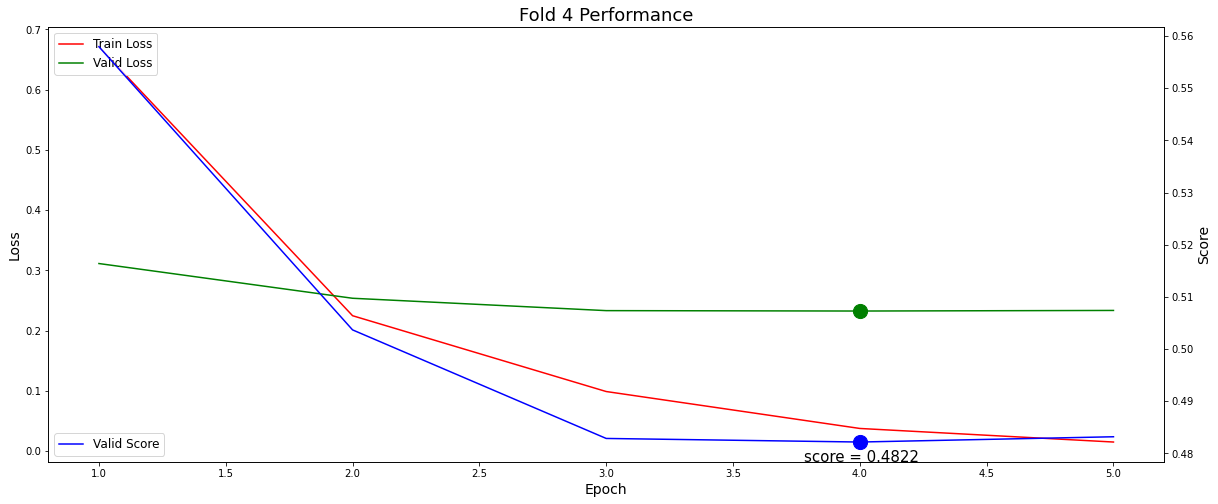

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5961 | val_loss = 0.3112 | val_score = 0.5578 | 5.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2123 | val_loss = 0.2488 | val_score = 0.4988 | 5.74 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0811 | val_loss = 0.2368 | val_score = 0.4867 | 3.95 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0252 | val_loss = 0.2345 | val_score = 0.4843 | 4.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0103 | val_loss = 0.2368 | val_score = 0.4866 | 3.20 min
-------------------------------------------------------
Best: score = 0.4843 (epoch 4)
-------------------------------------------------------


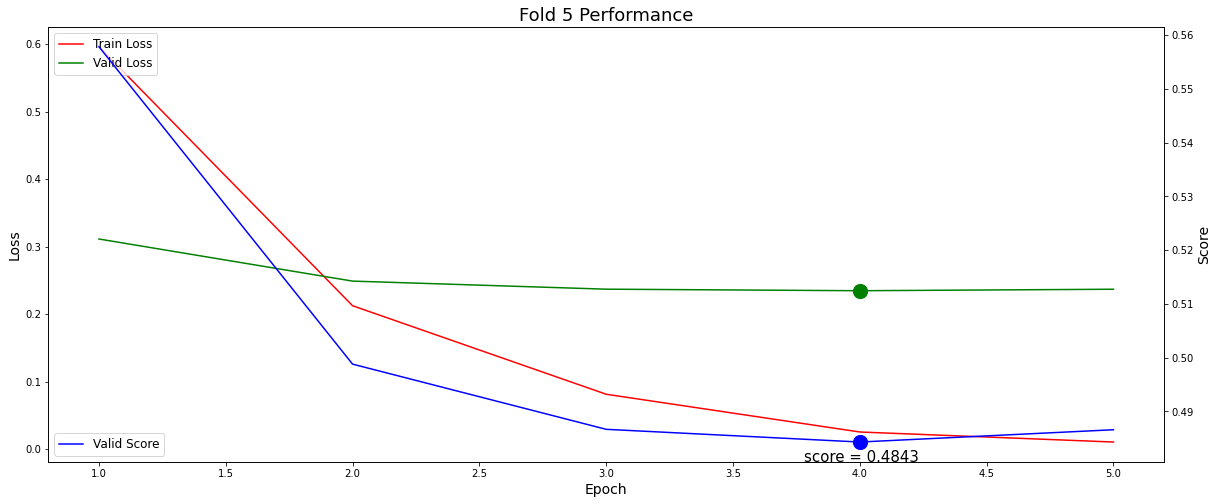

-------------------------------------------------------
REP 1/3 | OOF score = 0.4803
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6619 | val_loss = 0.3019 | val_score = 0.5494 | 5.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2292 | val_loss = 0.2499 | val_score = 0.4999 | 4.62 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0873 | val_loss = 0.2305 | val_score = 0.4801 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0236 | val_loss = 0.2317 | val_score = 0.4813 | 3.21 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0101 | val_loss = 0.2333 | val_score = 0.4830 | 3.20 min
-------------------------------------------------------
Best: score = 0.4801 (epoch 3)
-------------------------------------------------------


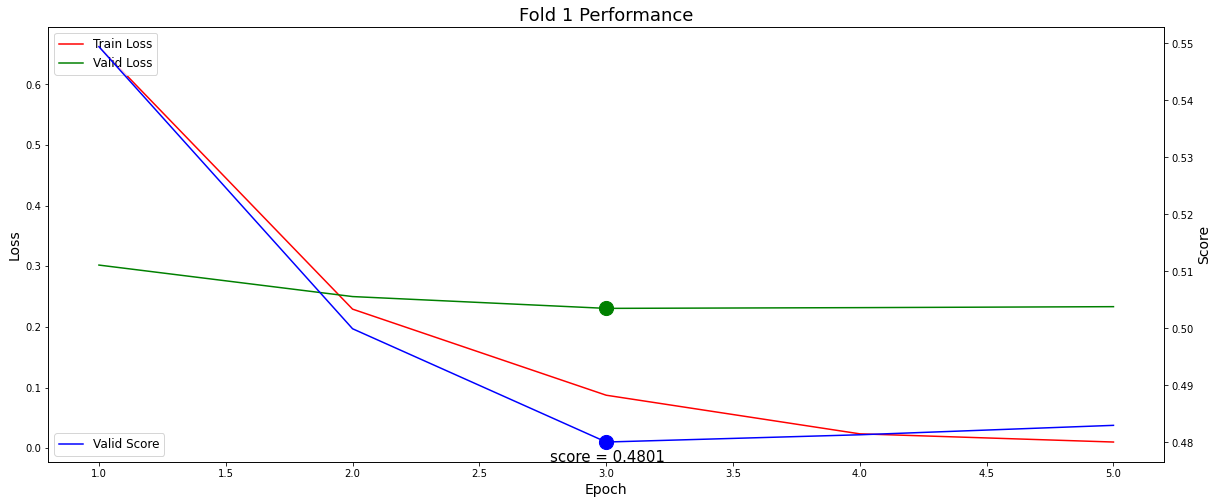

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.1506 | val_loss = 0.2995 | val_score = 0.5472 | 5.94 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2665 | val_loss = 0.2768 | val_score = 0.5262 | 3.75 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1069 | val_loss = 0.2479 | val_score = 0.4979 | 4.81 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0343 | val_loss = 0.2451 | val_score = 0.4950 | 4.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0131 | val_loss = 0.2448 | val_score = 0.4948 | 3.52 min
-------------------------------------------------------
Best: score = 0.4948 (epoch 5)
-------------------------------------------------------


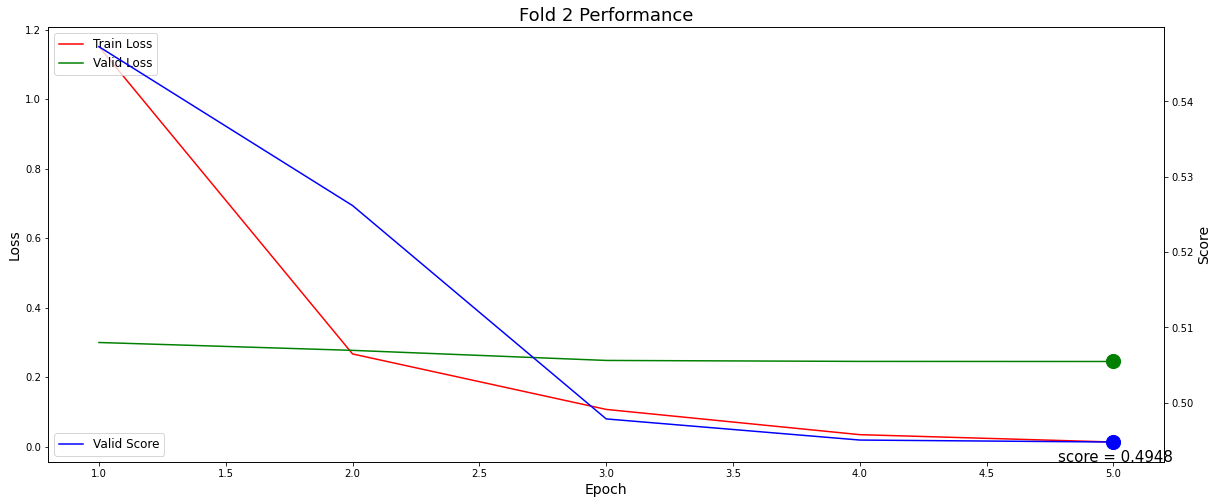

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5758 | val_loss = 0.2975 | val_score = 0.5454 | 5.63 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2285 | val_loss = 0.2521 | val_score = 0.5021 | 4.84 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0962 | val_loss = 0.2308 | val_score = 0.4804 | 4.12 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0398 | val_loss = 0.2356 | val_score = 0.4854 | 3.21 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0255 | val_loss = 0.2417 | val_score = 0.4917 | 3.20 min
-------------------------------------------------------
Best: score = 0.4804 (epoch 3)
-------------------------------------------------------


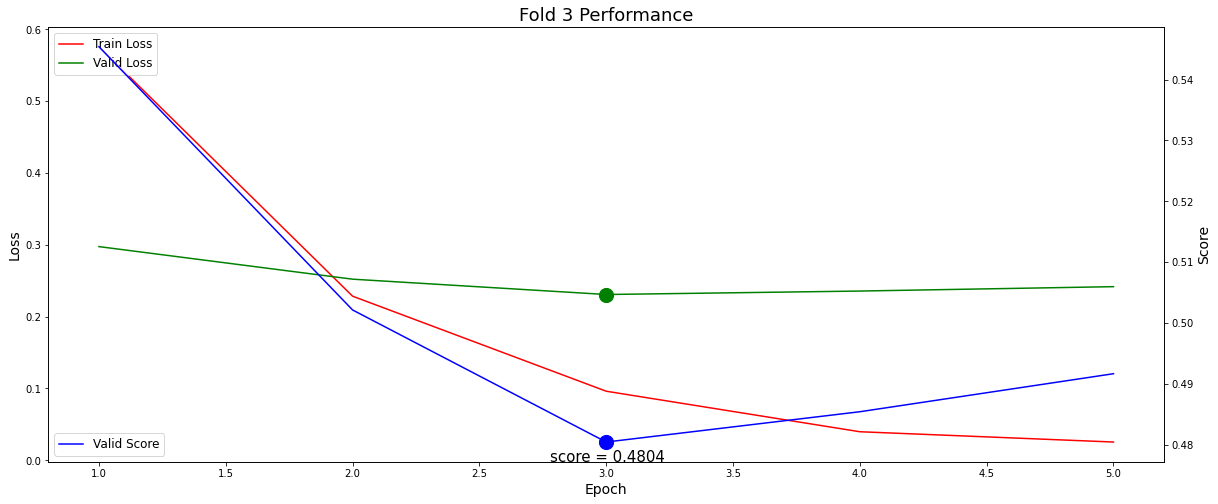

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6475 | val_loss = 0.3396 | val_score = 0.5828 | 6.14 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2267 | val_loss = 0.2584 | val_score = 0.5083 | 4.65 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0969 | val_loss = 0.2355 | val_score = 0.4852 | 3.91 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0316 | val_loss = 0.2326 | val_score = 0.4823 | 3.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0134 | val_loss = 0.2358 | val_score = 0.4856 | 3.17 min
-------------------------------------------------------
Best: score = 0.4823 (epoch 4)
-------------------------------------------------------


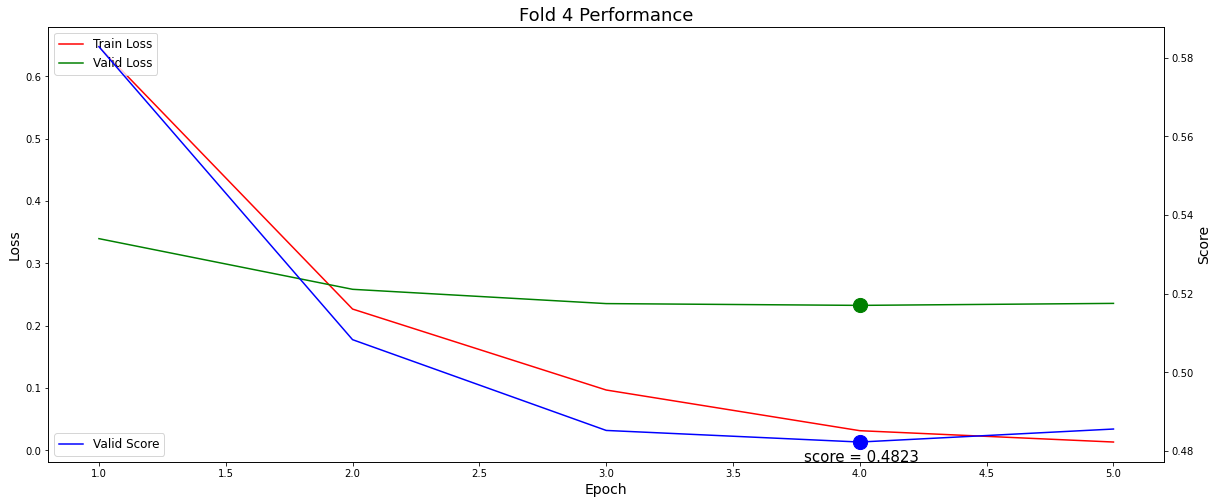

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5879 | val_loss = 0.3086 | val_score = 0.5555 | 6.16 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2271 | val_loss = 0.2513 | val_score = 0.5013 | 7.38 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0883 | val_loss = 0.2273 | val_score = 0.4767 | 6.45 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0310 | val_loss = 0.2280 | val_score = 0.4775 | 5.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0121 | val_loss = 0.2277 | val_score = 0.4772 | 5.34 min
-------------------------------------------------------
Best: score = 0.4767 (epoch 3)
-------------------------------------------------------


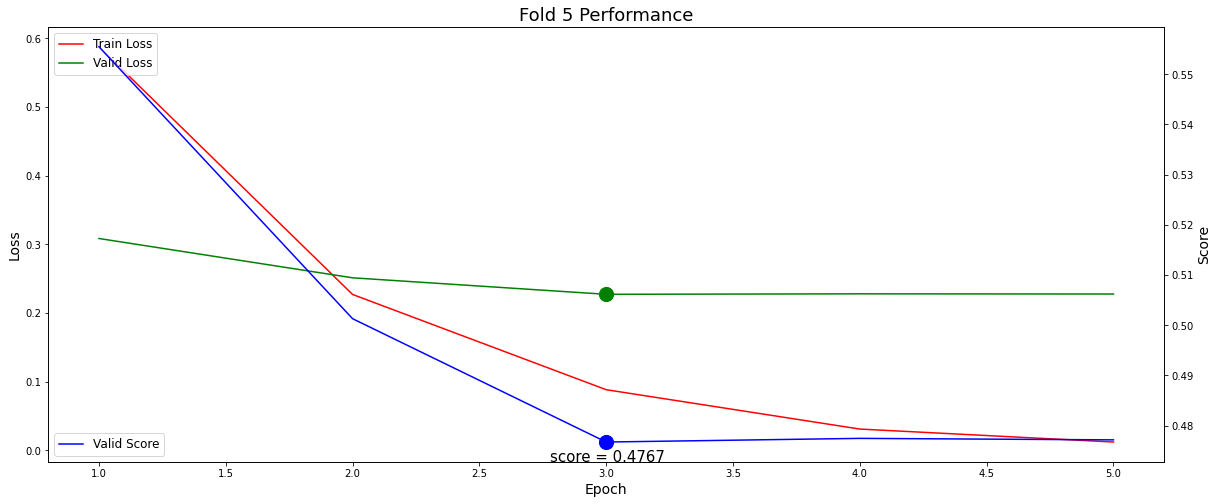

-------------------------------------------------------
REP 2/3 | OOF score = 0.4829
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6441 | val_loss = 0.3071 | val_score = 0.5542 | 8.33 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2329 | val_loss = 0.2346 | val_score = 0.4843 | 6.65 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0790 | val_loss = 0.2249 | val_score = 0.4742 | 6.35 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0215 | val_loss = 0.2228 | val_score = 0.4721 | 6.31 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0085 | val_loss = 0.2239 | val_score = 0.4732 | 5.70 min
-------------------------------------------------------
Best: score = 0.4721 (epoch 4)
-------------------------------------------------------


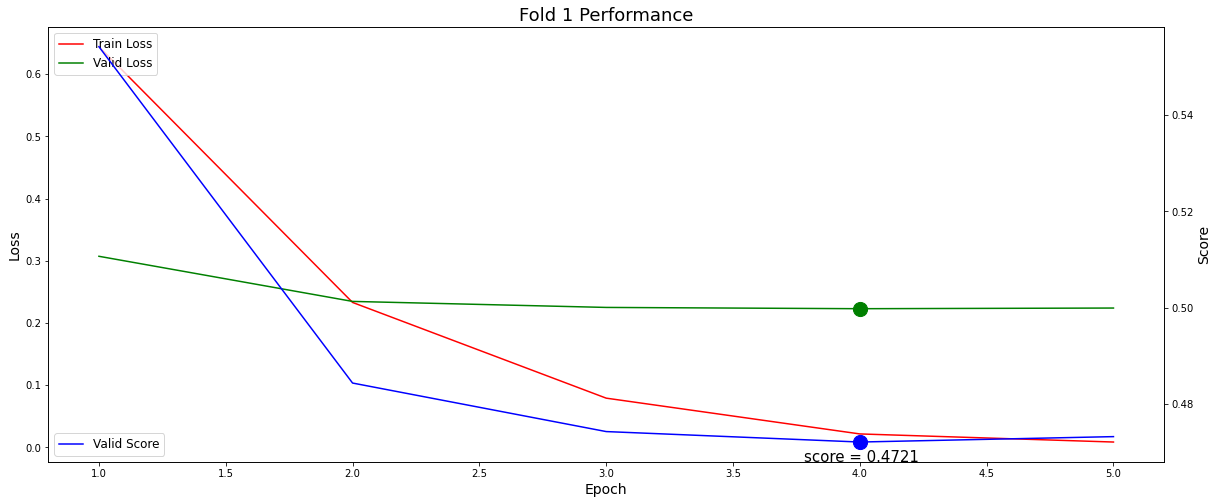

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.0430 | val_loss = 0.2940 | val_score = 0.5422 | 8.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2366 | val_loss = 0.2348 | val_score = 0.4846 | 6.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0867 | val_loss = 0.2187 | val_score = 0.4676 | 6.20 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0291 | val_loss = 0.2169 | val_score = 0.4657 | 5.88 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0119 | val_loss = 0.2179 | val_score = 0.4668 | 4.62 min
-------------------------------------------------------
Best: score = 0.4657 (epoch 4)
-------------------------------------------------------


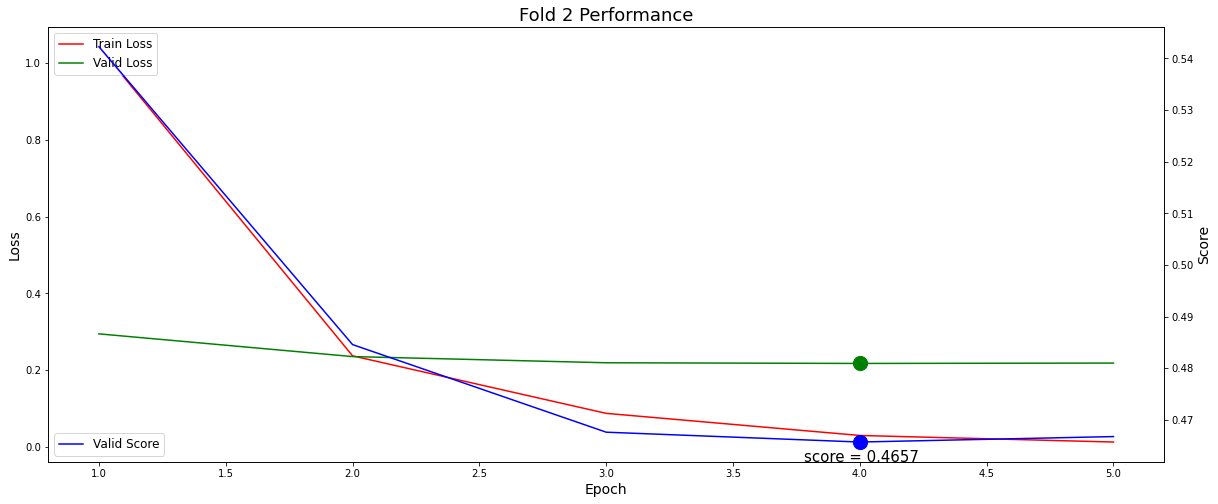

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5700 | val_loss = 0.2883 | val_score = 0.5369 | 8.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2612 | val_loss = 0.2329 | val_score = 0.4825 | 6.16 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0997 | val_loss = 0.2275 | val_score = 0.4769 | 6.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0332 | val_loss = 0.2265 | val_score = 0.4759 | 5.42 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0147 | val_loss = 0.2275 | val_score = 0.4770 | 5.73 min
-------------------------------------------------------
Best: score = 0.4759 (epoch 4)
-------------------------------------------------------


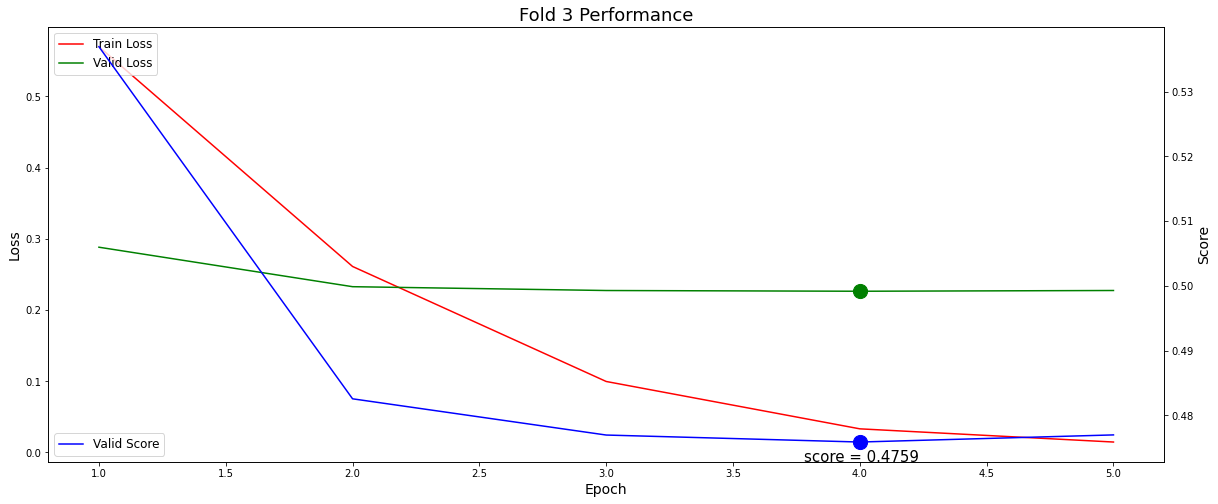

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6521 | val_loss = 0.3247 | val_score = 0.5699 | 7.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2378 | val_loss = 0.2499 | val_score = 0.4999 | 7.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0851 | val_loss = 0.2337 | val_score = 0.4834 | 6.58 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0282 | val_loss = 0.2377 | val_score = 0.4876 | 5.56 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0116 | val_loss = 0.2362 | val_score = 0.4860 | 4.98 min
-------------------------------------------------------
Best: score = 0.4834 (epoch 3)
-------------------------------------------------------


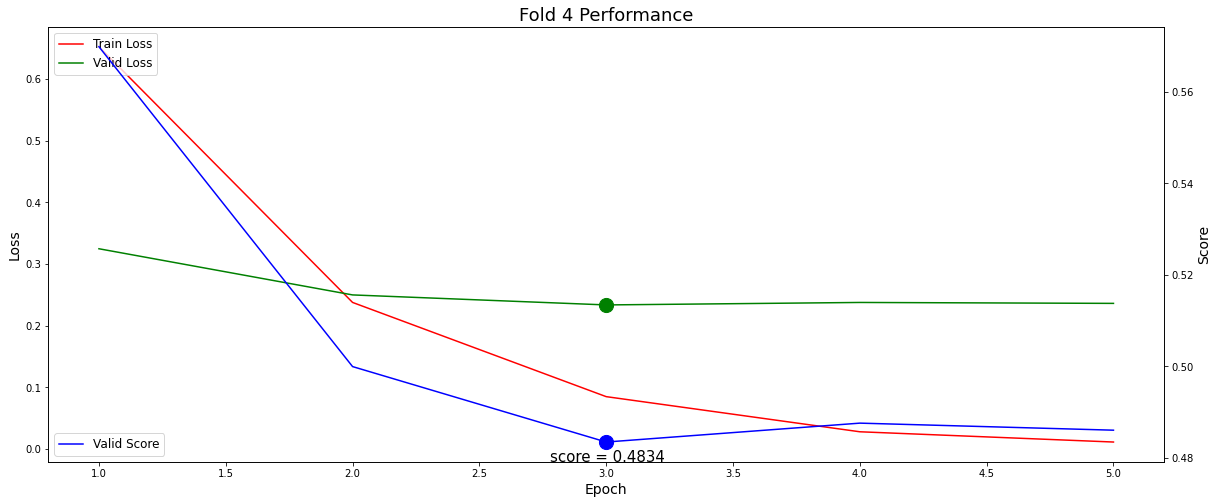

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6563 | val_loss = 0.3668 | val_score = 0.6057 | 8.14 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2538 | val_loss = 0.2572 | val_score = 0.5071 | 7.70 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1019 | val_loss = 0.2529 | val_score = 0.5029 | 5.93 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0308 | val_loss = 0.2487 | val_score = 0.4987 | 5.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0127 | val_loss = 0.2480 | val_score = 0.4980 | 5.65 min
-------------------------------------------------------
Best: score = 0.4980 (epoch 5)
-------------------------------------------------------


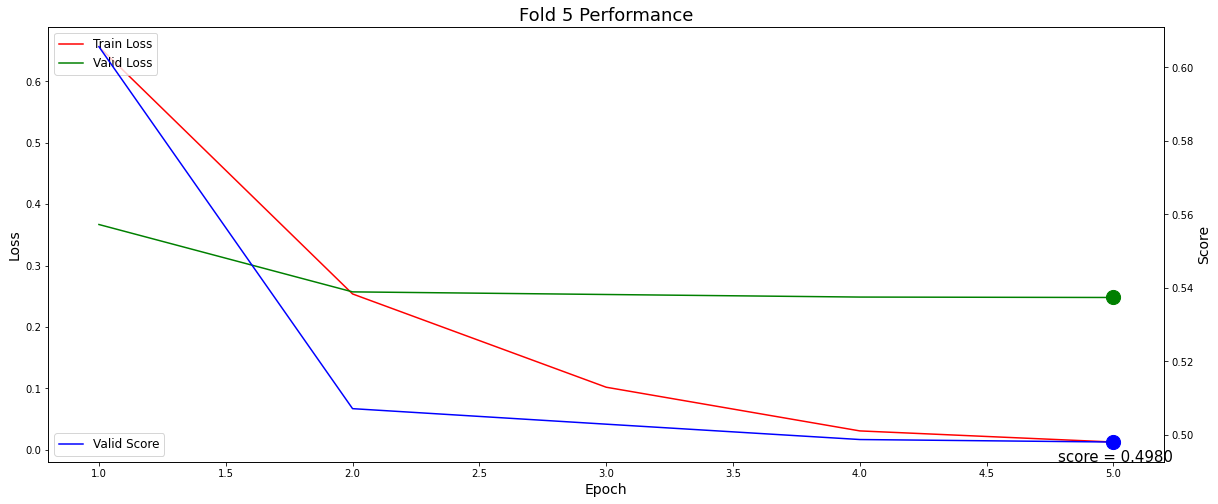

-------------------------------------------------------
REP 3/3 | OOF score = 0.4790
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4807
-------------------------------------------------------

Finished in 388.19 minutes


In [27]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [28]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 14.00 minutes


In [29]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4808
OOF bag score = 0.4725
----------------------


In [30]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()

# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 62     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle     = 0    # probability of batch-level sentence shuffle
    p_translate = 0     # probability of swapping a sentence with backtranslation
    noise_alpha = 0     # SD-adjusted noise magnitude in the targe values
    
    # SWA
    swa = False
    
    # architecture
    backbone       = 'roberta-large'  # transformer backbone   
    hidden_size    = 1024             # size of the hidden layer
    pretrained     = True            # pretrained weights [False, True, path]
    freeze_embed   = True            # whether to freeze the embedding layer
    freeze_layers  = 0               # how many deep transformer layers to freeze
    init_range     = None            # weight init range for new layers (None or float)
    hidden_dropout = 0.0             # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 6       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.95  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 20    # no. cases per batch 

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle
import ipdb

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZjVlMTZiZS1kYjcyLTRmZmQtYjJhYS0xMmIyYzdiNzFkMzcifQ==',
                 project_qualified_name = 'ml_comps/readability')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-500


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 322
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [10]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.1821 vs 0.1855 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
0, 250, 5973, 2060, 1023, 3760, 21, 1613, 6, 29396, 21, 1613, 4, 20, 929    |           -3.081337118
0, 243, 21, 2047, 30, 5, 5402, 604, 9, 2240, 14, 7765, 12749, 18, 19023     |           -2.145248365
0, 133, 6700, 11, 10, 3027, 2352, 2322, 5, 1946, 9, 80, 4, 20, 32           |           -1.400318025
0, 133, 31918, 3203, 40968, 62, 8, 159, 5, 251, 6, 614, 12, 1755, 6691      |           -0.495298635
0, 713, 10829, 338, 1512, 281, 21, 39676, 12, 7109, 107, 793, 4, 91, 21     |            0.245805709
----------------------------------------------------------------------------------------------------
<s>It was believed by the principal men of Virginia that Talbot's sympath   |           -3.081337118
<s>This Pedrarias was seventy-two years old. He was     

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7417 | val_loss = 0.2736 | val_score = 0.5231 | 6.39 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2240 | val_loss = 0.2592 | val_score = 0.5091 | 3.85 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0821 | val_loss = 0.2337 | val_score = 0.4834 | 5.26 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0241 | val_loss = 0.2337 | val_score = 0.4834 | 3.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0096 | val_loss = 0.2375 | val_score = 0.4873 | 3.59 min
-------------------------------------------------------
Best: score = 0.4834 (epoch 4)
-------------------------------------------------------


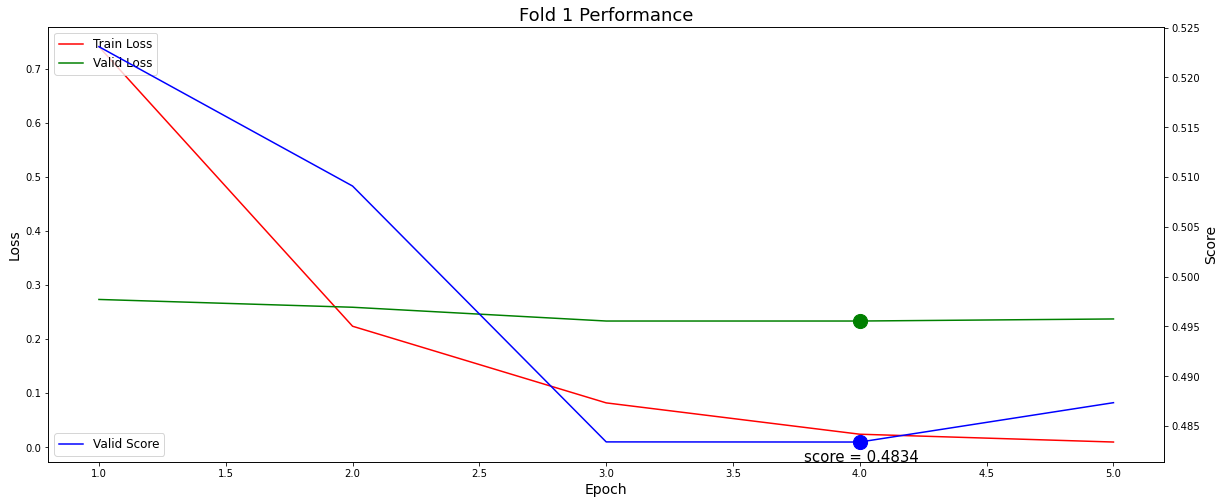

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.9180 | val_loss = 0.2837 | val_score = 0.5327 | 6.78 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2793 | val_loss = 0.2597 | val_score = 0.5096 | 4.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0945 | val_loss = 0.2332 | val_score = 0.4829 | 5.79 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0280 | val_loss = 0.2289 | val_score = 0.4784 | 4.69 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0117 | val_loss = 0.2309 | val_score = 0.4805 | 3.82 min
-------------------------------------------------------
Best: score = 0.4784 (epoch 4)
-------------------------------------------------------


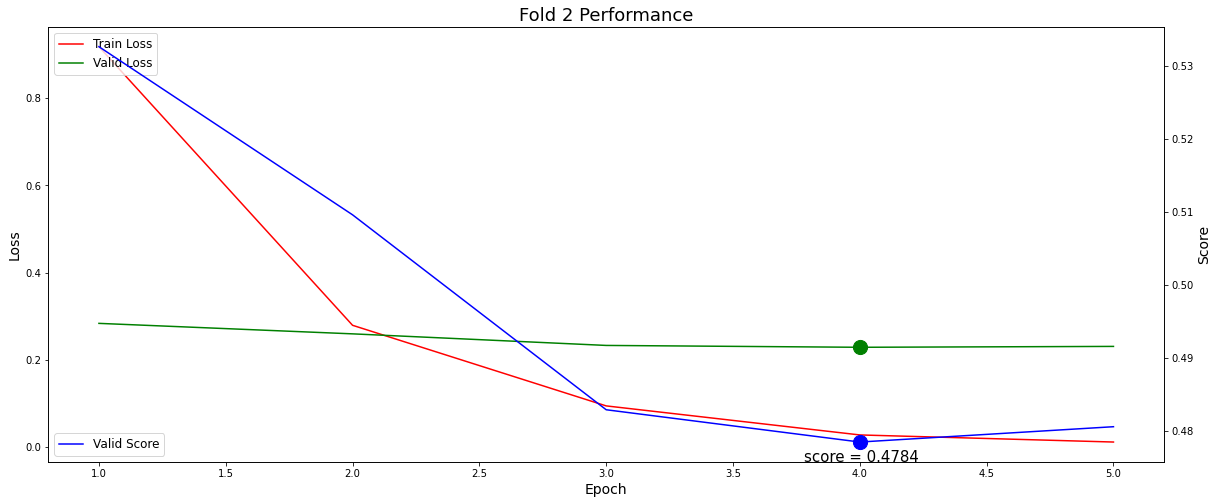

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5946 | val_loss = 0.3060 | val_score = 0.5531 | 6.33 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2383 | val_loss = 0.2459 | val_score = 0.4959 | 4.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0873 | val_loss = 0.2307 | val_score = 0.4803 | 5.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0258 | val_loss = 0.2246 | val_score = 0.4740 | 4.91 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0113 | val_loss = 0.2291 | val_score = 0.4786 | 3.84 min
-------------------------------------------------------
Best: score = 0.4740 (epoch 4)
-------------------------------------------------------


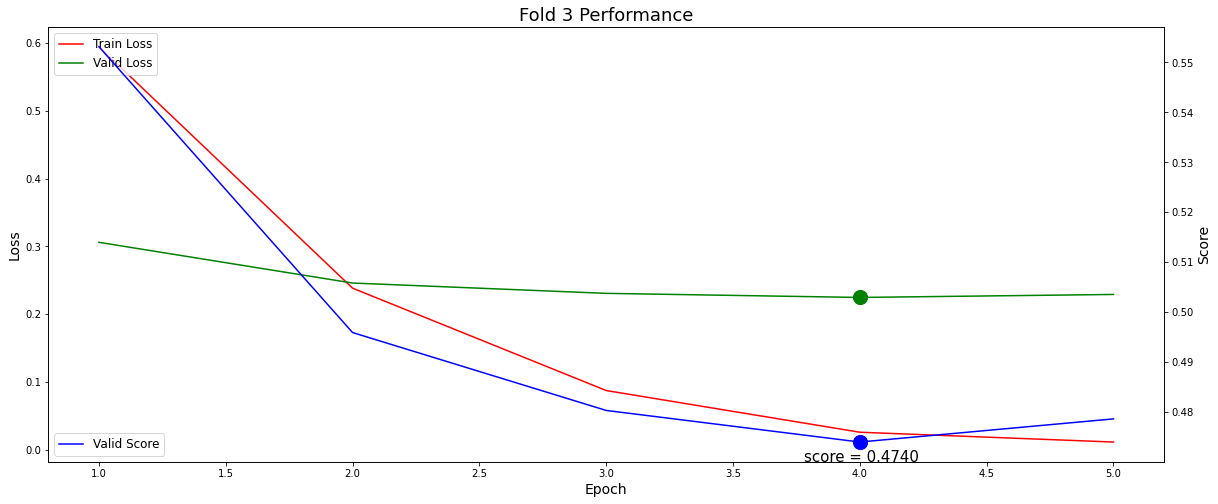

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6670 | val_loss = 0.3350 | val_score = 0.5788 | 6.67 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2657 | val_loss = 0.2602 | val_score = 0.5101 | 5.25 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1373 | val_loss = 0.2385 | val_score = 0.4883 | 4.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0575 | val_loss = 0.2332 | val_score = 0.4829 | 4.41 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0259 | val_loss = 0.2324 | val_score = 0.4821 | 4.14 min
-------------------------------------------------------
Best: score = 0.4821 (epoch 5)
-------------------------------------------------------


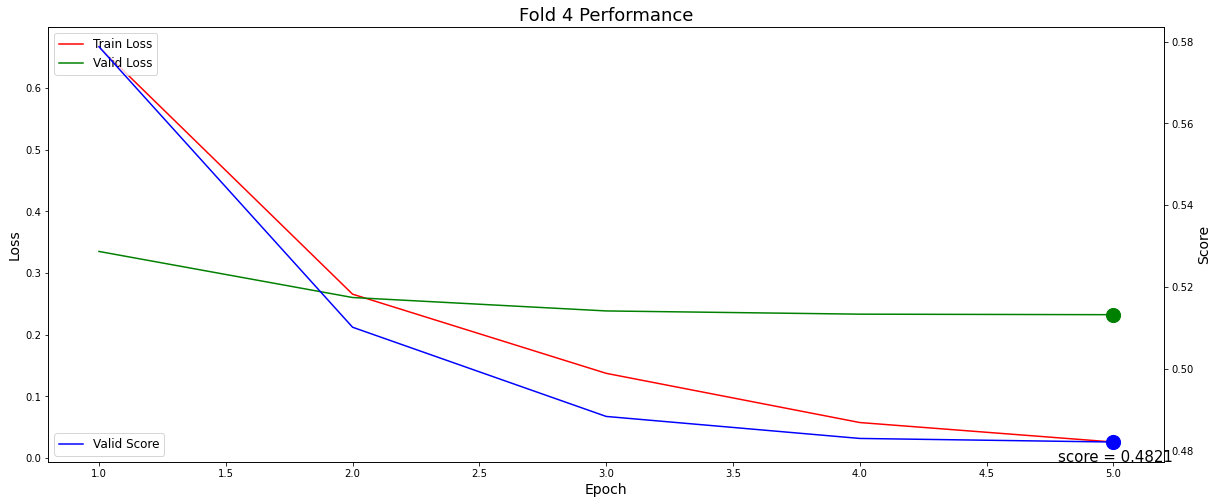

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5396 | val_loss = 0.3145 | val_score = 0.5608 | 5.44 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2153 | val_loss = 0.2533 | val_score = 0.5033 | 4.21 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0881 | val_loss = 0.2388 | val_score = 0.4887 | 3.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0281 | val_loss = 0.2330 | val_score = 0.4827 | 3.48 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0119 | val_loss = 0.2358 | val_score = 0.4856 | 3.24 min
-------------------------------------------------------
Best: score = 0.4827 (epoch 4)
-------------------------------------------------------


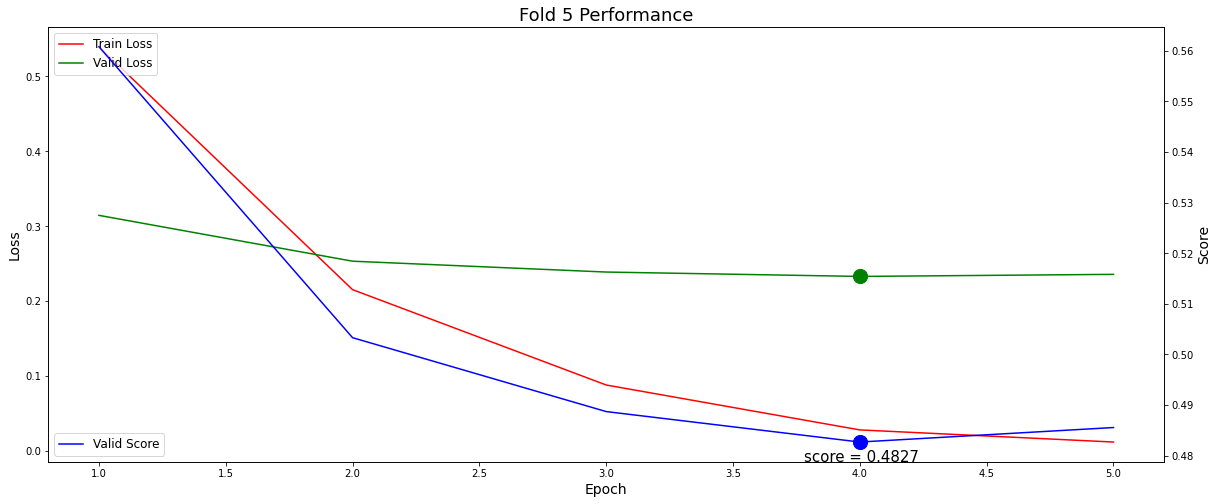

-------------------------------------------------------
REP 1/3 | OOF score = 0.4801
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7249 | val_loss = 0.3017 | val_score = 0.5493 | 5.77 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2388 | val_loss = 0.2456 | val_score = 0.4955 | 4.50 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0894 | val_loss = 0.2275 | val_score = 0.4769 | 3.97 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0244 | val_loss = 0.2286 | val_score = 0.4781 | 3.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0103 | val_loss = 0.2299 | val_score = 0.4795 | 3.21 min
-------------------------------------------------------
Best: score = 0.4769 (epoch 3)
-------------------------------------------------------


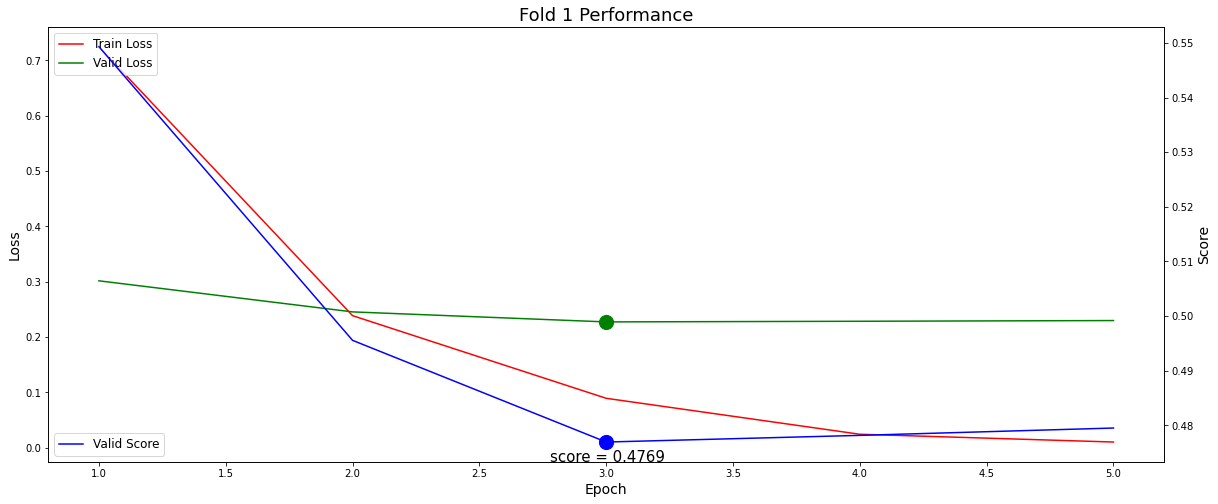

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 1.0369 | val_loss = 0.3121 | val_score = 0.5587 | 5.52 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2709 | val_loss = 0.2535 | val_score = 0.5035 | 4.44 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0881 | val_loss = 0.2346 | val_score = 0.4844 | 4.17 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0284 | val_loss = 0.2317 | val_score = 0.4814 | 3.93 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0108 | val_loss = 0.2315 | val_score = 0.4811 | 3.45 min
-------------------------------------------------------
Best: score = 0.4811 (epoch 5)
-------------------------------------------------------


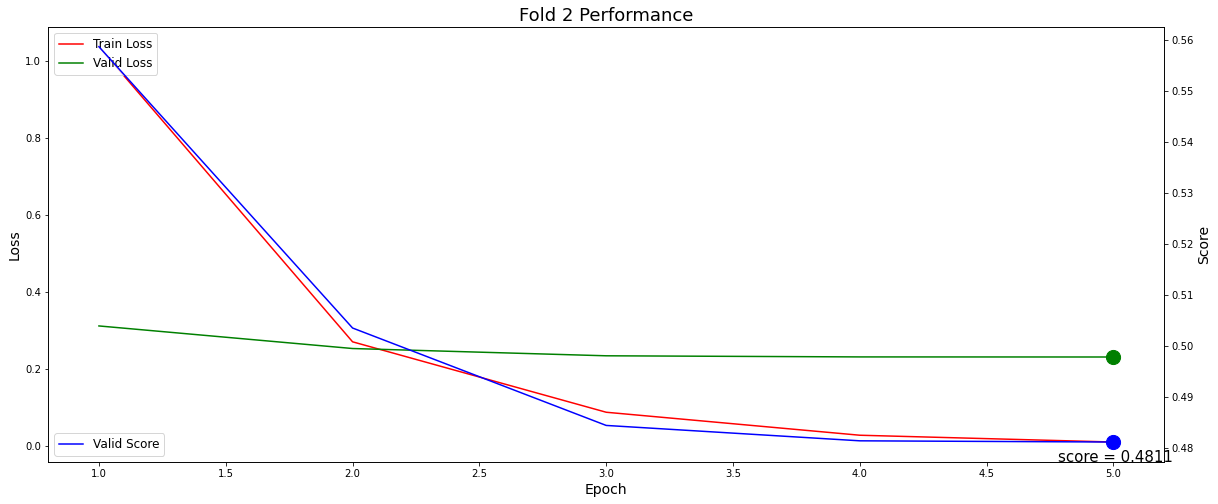

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5460 | val_loss = 0.2847 | val_score = 0.5336 | 4.94 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.1926 | val_loss = 0.2489 | val_score = 0.4989 | 3.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0785 | val_loss = 0.2296 | val_score = 0.4792 | 3.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0229 | val_loss = 0.2295 | val_score = 0.4791 | 3.48 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0093 | val_loss = 0.2315 | val_score = 0.4811 | 3.25 min
-------------------------------------------------------
Best: score = 0.4791 (epoch 4)
-------------------------------------------------------


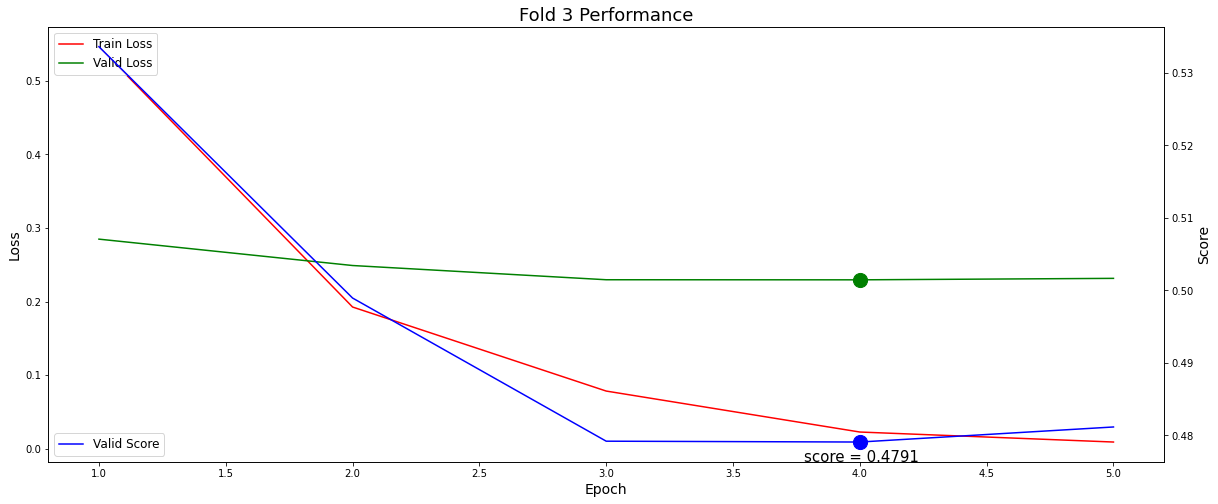

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6296 | val_loss = 0.3132 | val_score = 0.5597 | 5.87 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2173 | val_loss = 0.2517 | val_score = 0.5017 | 4.68 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0772 | val_loss = 0.2397 | val_score = 0.4896 | 3.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0282 | val_loss = 0.2367 | val_score = 0.4865 | 3.74 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0107 | val_loss = 0.2365 | val_score = 0.4863 | 3.49 min
-------------------------------------------------------
Best: score = 0.4863 (epoch 5)
-------------------------------------------------------


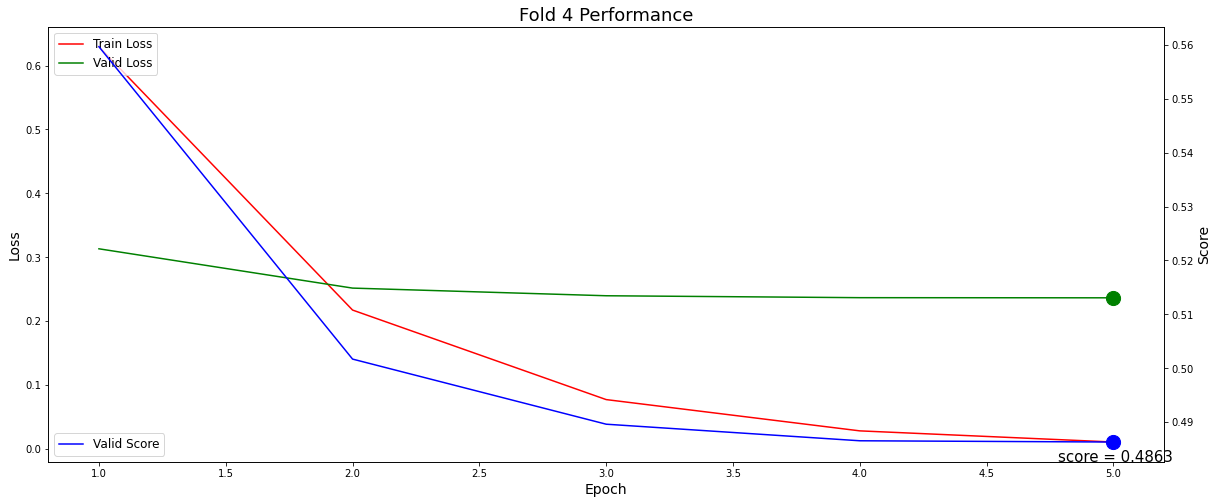

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5451 | val_loss = 0.2687 | val_score = 0.5184 | 5.86 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2677 | val_loss = 0.2417 | val_score = 0.4916 | 4.20 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1960 | val_loss = 0.2340 | val_score = 0.4837 | 3.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0444 | val_loss = 0.2281 | val_score = 0.4775 | 3.97 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0201 | val_loss = 0.2252 | val_score = 0.4745 | 3.72 min
-------------------------------------------------------
Best: score = 0.4745 (epoch 5)
-------------------------------------------------------


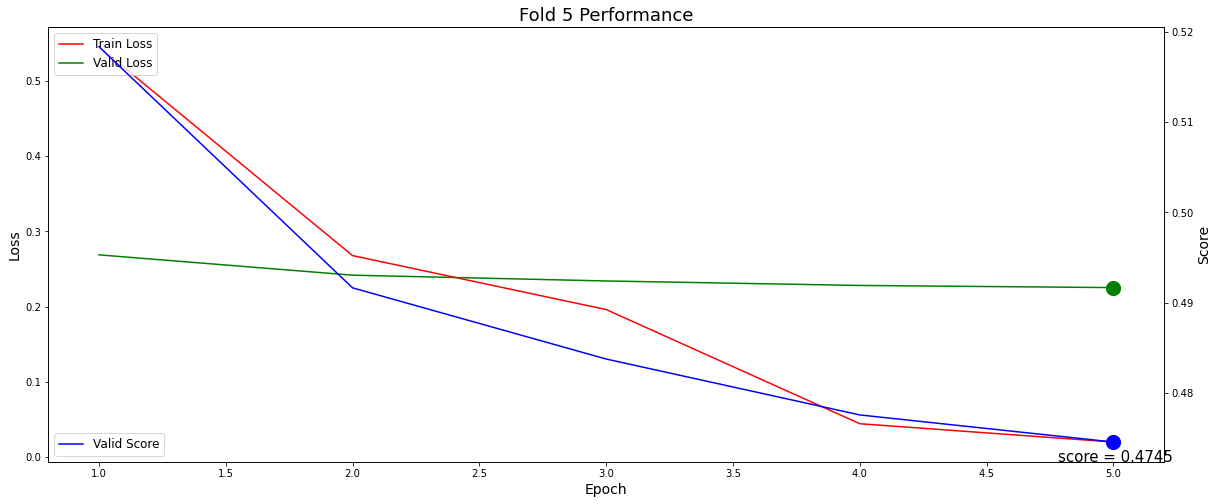

-------------------------------------------------------
REP 2/3 | OOF score = 0.4796
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7320 | val_loss = 0.2954 | val_score = 0.5435 | 5.17 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2350 | val_loss = 0.2420 | val_score = 0.4919 | 4.45 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0943 | val_loss = 0.2270 | val_score = 0.4765 | 3.96 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0305 | val_loss = 0.2236 | val_score = 0.4729 | 4.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0126 | val_loss = 0.2241 | val_score = 0.4734 | 3.24 min
-------------------------------------------------------
Best: score = 0.4729 (epoch 4)
-------------------------------------------------------


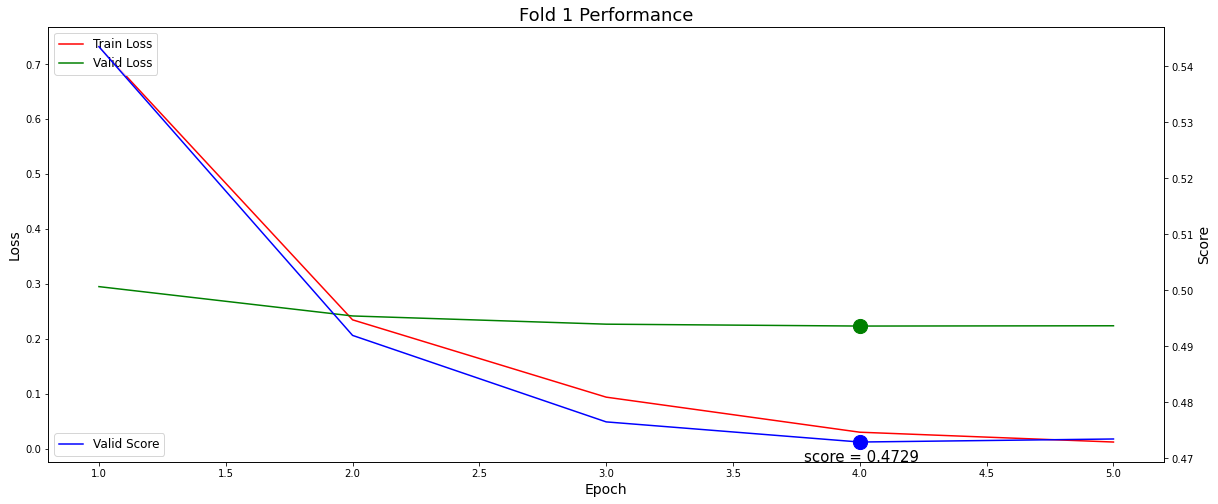

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.9062 | val_loss = 0.2963 | val_score = 0.5444 | 6.38 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2478 | val_loss = 0.2314 | val_score = 0.4810 | 4.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0881 | val_loss = 0.2176 | val_score = 0.4665 | 3.97 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0289 | val_loss = 0.2170 | val_score = 0.4659 | 3.48 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0117 | val_loss = 0.2186 | val_score = 0.4675 | 3.25 min
-------------------------------------------------------
Best: score = 0.4659 (epoch 4)
-------------------------------------------------------


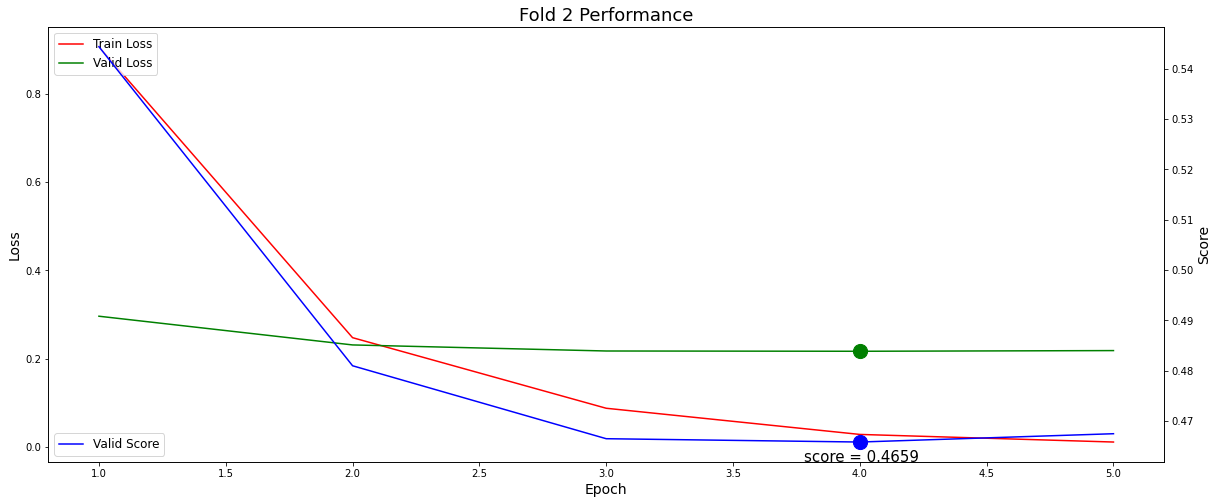

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5516 | val_loss = 0.2785 | val_score = 0.5277 | 5.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2426 | val_loss = 0.2355 | val_score = 0.4852 | 4.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0833 | val_loss = 0.2212 | val_score = 0.4703 | 4.45 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0267 | val_loss = 0.2238 | val_score = 0.4731 | 3.25 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0113 | val_loss = 0.2278 | val_score = 0.4773 | 3.26 min
-------------------------------------------------------
Best: score = 0.4703 (epoch 3)
-------------------------------------------------------


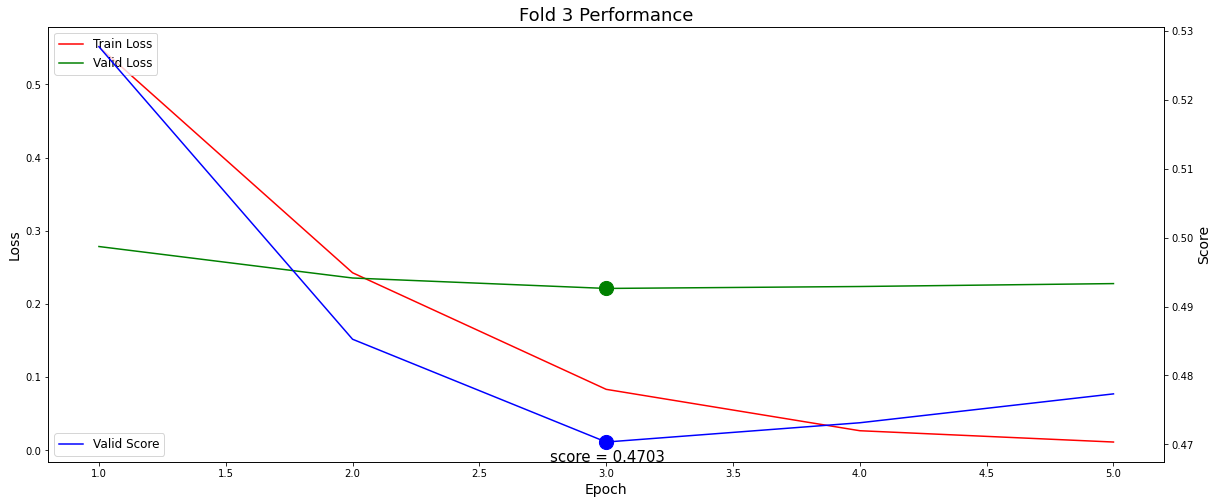

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6461 | val_loss = 0.2965 | val_score = 0.5445 | 5.92 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2703 | val_loss = 0.2367 | val_score = 0.4865 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0897 | val_loss = 0.2322 | val_score = 0.4819 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0272 | val_loss = 0.2301 | val_score = 0.4797 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0112 | val_loss = 0.2312 | val_score = 0.4808 | 3.26 min
-------------------------------------------------------
Best: score = 0.4797 (epoch 4)
-------------------------------------------------------


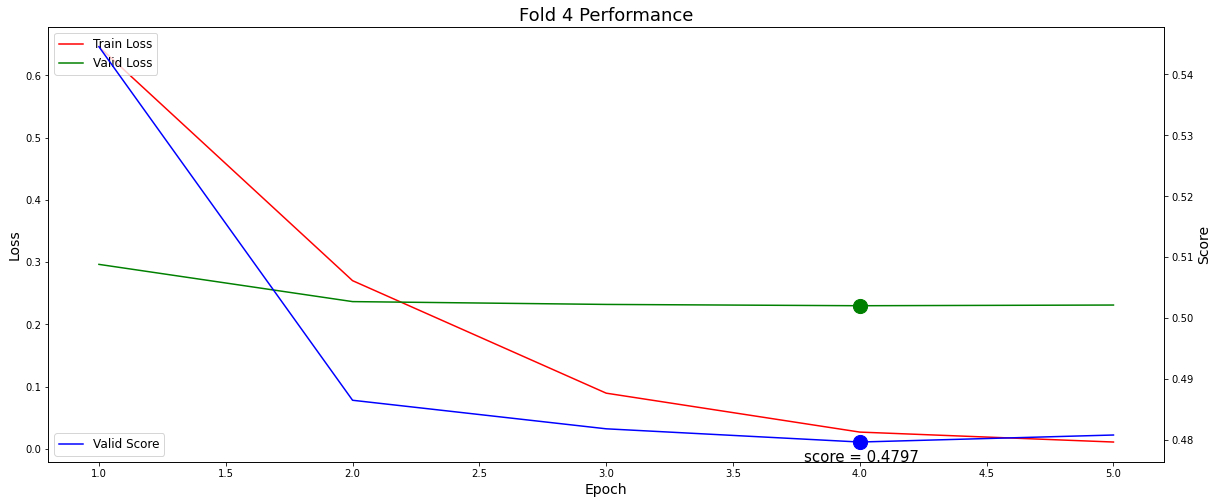

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5729 | val_loss = 0.3271 | val_score = 0.5719 | 5.91 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2261 | val_loss = 0.2468 | val_score = 0.4968 | 5.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0922 | val_loss = 0.2397 | val_score = 0.4896 | 3.74 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0300 | val_loss = 0.2347 | val_score = 0.4845 | 4.23 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0136 | val_loss = 0.2364 | val_score = 0.4863 | 3.28 min
-------------------------------------------------------
Best: score = 0.4845 (epoch 4)
-------------------------------------------------------


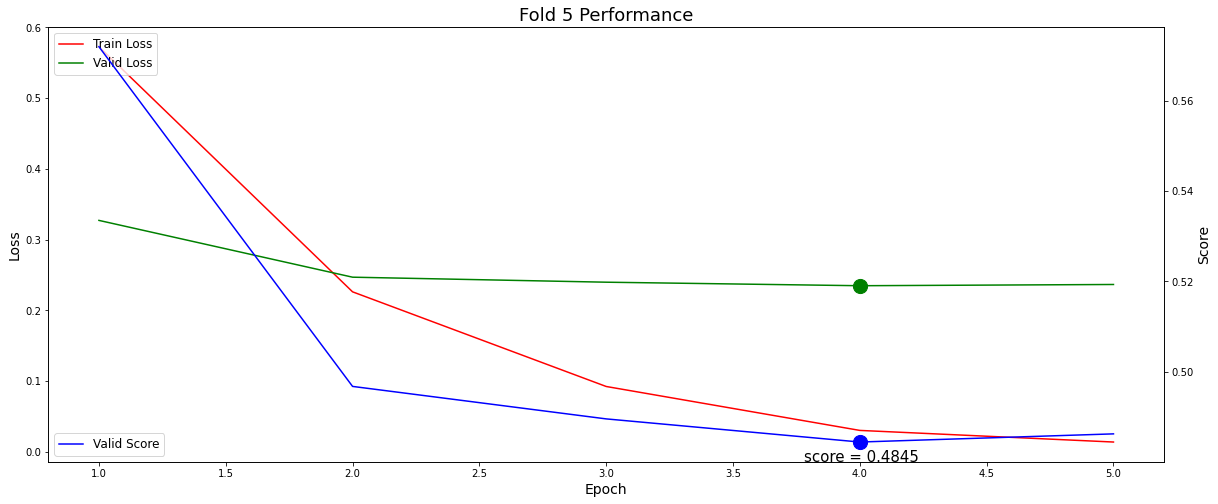

-------------------------------------------------------
REP 3/3 | OOF score = 0.4746
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4781
-------------------------------------------------------

Finished in 335.01 minutes


In [12]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [13]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 11.66 minutes


In [14]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4781
OOF bag score = 0.4706
----------------------


In [15]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()

# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 1        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 63     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle     = 0    # probability of batch-level sentence shuffle
    p_translate = 0     # probability of swapping a sentence with backtranslation
    noise_alpha = 0     # SD-adjusted noise magnitude in the targe values
    
    # SWA
    swa = False
    
    # architecture
    backbone       = 'roberta-large'  # transformer backbone   
    hidden_size    = 1024             # size of the hidden layer
    pretrained     = True            # pretrained weights [False, True, path]
    freeze_embed   = True            # whether to freeze the embedding layer
    freeze_layers  = 0               # how many deep transformer layers to freeze
    init_range     = None            # weight init range for new layers (None or float)
    hidden_dropout = 0.0             # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 7       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.95  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 20    # no. cases per batch 

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['save_all']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2

# 2. PREPARATIONS

In [4]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd
import torch

import os
import sys
import time
import pickle
import ipdb

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

In [5]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [6]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzZjVlMTZiZS1kYjcyLTRmZmQtYjJhYS0xMmIyYzdiNzFkMzcifQ==',
                 project_qualified_name = 'ml_comps/readability')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-490


In [8]:
####### SETTINGS

warnings.filterwarnings('ignore')        # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [9]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

maximum length: 322
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,227,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,238,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,225,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,224,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [10]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.0807 vs 0.0951 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
0, 250, 5973, 2060, 1023, 3760, 21, 1613, 6, 29396, 21, 1613, 4, 20, 929    |           -3.081337118
0, 243, 21, 2047, 30, 5, 5402, 604, 9, 2240, 14, 7765, 12749, 18, 19023     |           -2.145248365
0, 133, 6700, 11, 10, 3027, 2352, 2322, 5, 1946, 9, 80, 4, 20, 32           |           -1.400318025
0, 133, 31918, 3203, 40968, 62, 8, 159, 5, 251, 6, 614, 12, 1755, 6691      |           -0.495298635
0, 713, 10829, 338, 1512, 281, 21, 39676, 12, 7109, 107, 793, 4, 91, 21     |            0.245805709
----------------------------------------------------------------------------------------------------
<s>It was believed by the principal men of Virginia that Talbot's sympath   |           -3.081337118
<s>This Pedrarias was seventy-two years old. He was     

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7803 | val_loss = 0.2659 | val_score = 0.5157 | 5.82 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2244 | val_loss = 0.2558 | val_score = 0.5058 | 3.89 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0868 | val_loss = 0.2342 | val_score = 0.4840 | 3.91 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0284 | val_loss = 0.2325 | val_score = 0.4822 | 3.89 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0119 | val_loss = 0.2352 | val_score = 0.4850 | 3.18 min
-------------------------------------------------------
Best: score = 0.4822 (epoch 4)
-------------------------------------------------------


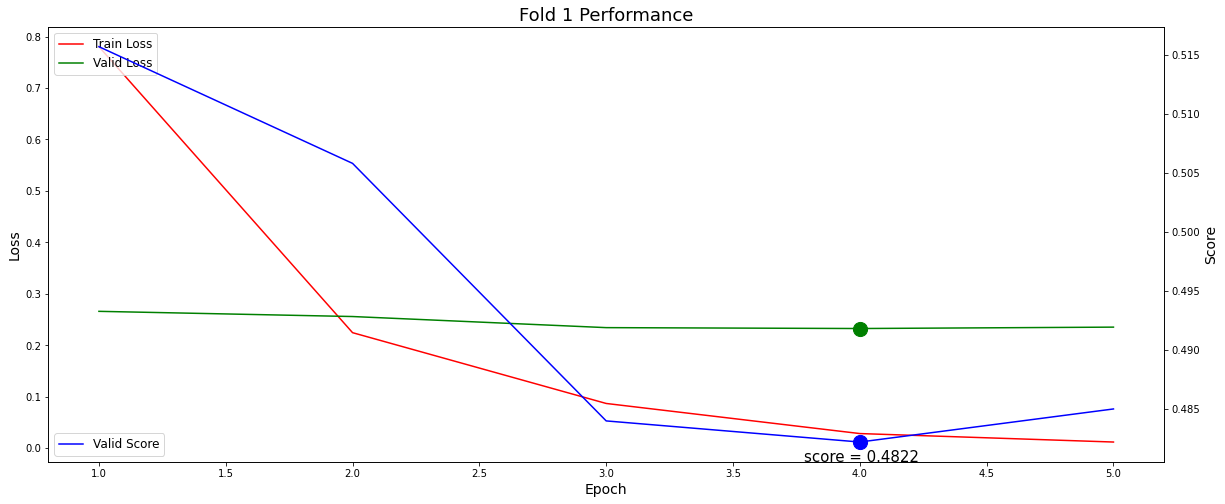

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8732 | val_loss = 0.3222 | val_score = 0.5676 | 5.18 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2792 | val_loss = 0.2582 | val_score = 0.5081 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1064 | val_loss = 0.2327 | val_score = 0.4824 | 4.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0336 | val_loss = 0.2313 | val_score = 0.4810 | 3.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0147 | val_loss = 0.2323 | val_score = 0.4819 | 3.23 min
-------------------------------------------------------
Best: score = 0.4810 (epoch 4)
-------------------------------------------------------


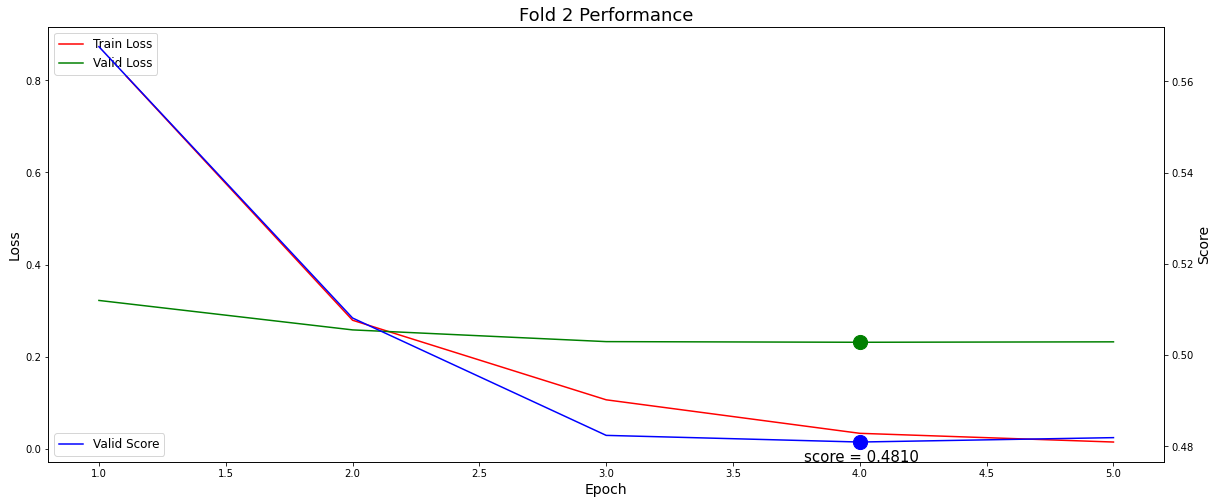

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5918 | val_loss = 0.2997 | val_score = 0.5474 | 5.52 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2243 | val_loss = 0.2509 | val_score = 0.5009 | 4.48 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0784 | val_loss = 0.2284 | val_score = 0.4780 | 4.69 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0224 | val_loss = 0.2241 | val_score = 0.4734 | 4.45 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0097 | val_loss = 0.2264 | val_score = 0.4758 | 3.25 min
-------------------------------------------------------
Best: score = 0.4734 (epoch 4)
-------------------------------------------------------


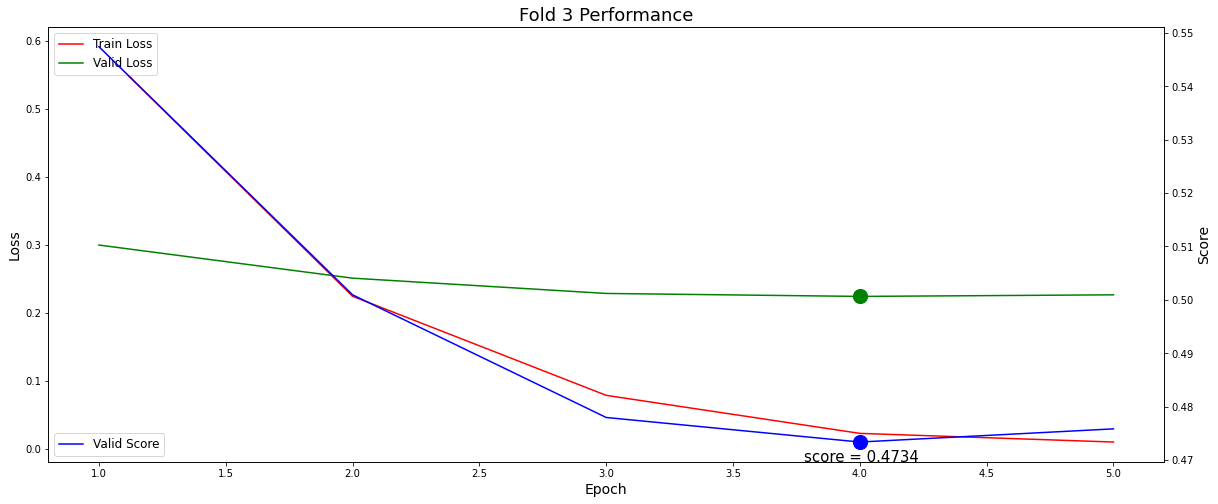

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6038 | val_loss = 0.2965 | val_score = 0.5445 | 5.23 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2228 | val_loss = 0.2465 | val_score = 0.4965 | 5.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0808 | val_loss = 0.2391 | val_score = 0.4890 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0270 | val_loss = 0.2358 | val_score = 0.4856 | 4.25 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0115 | val_loss = 0.2374 | val_score = 0.4872 | 3.28 min
-------------------------------------------------------
Best: score = 0.4856 (epoch 4)
-------------------------------------------------------


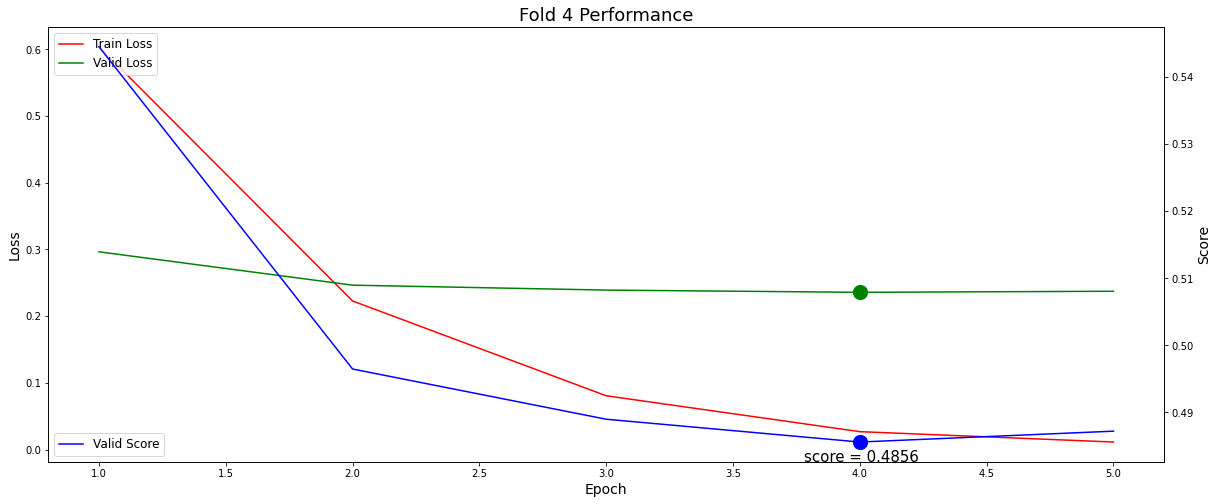

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5862 | val_loss = 0.3114 | val_score = 0.5580 | 5.65 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2705 | val_loss = 0.2733 | val_score = 0.5228 | 3.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1140 | val_loss = 0.2517 | val_score = 0.5017 | 4.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0372 | val_loss = 0.2437 | val_score = 0.4937 | 4.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0170 | val_loss = 0.2453 | val_score = 0.4952 | 3.27 min
-------------------------------------------------------
Best: score = 0.4937 (epoch 4)
-------------------------------------------------------


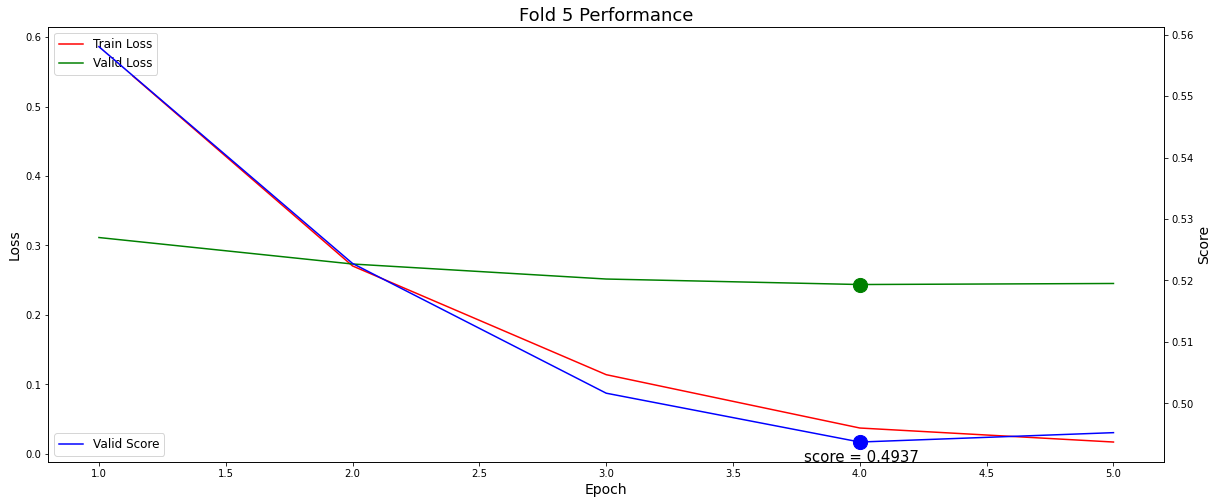

-------------------------------------------------------
REP 1/3 | OOF score = 0.4832
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8037 | val_loss = 0.2961 | val_score = 0.5442 | 5.42 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2265 | val_loss = 0.2498 | val_score = 0.4998 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0976 | val_loss = 0.2324 | val_score = 0.4821 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0287 | val_loss = 0.2330 | val_score = 0.4827 | 3.28 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0125 | val_loss = 0.2351 | val_score = 0.4849 | 3.28 min
-------------------------------------------------------
Best: score = 0.4821 (epoch 3)
-------------------------------------------------------


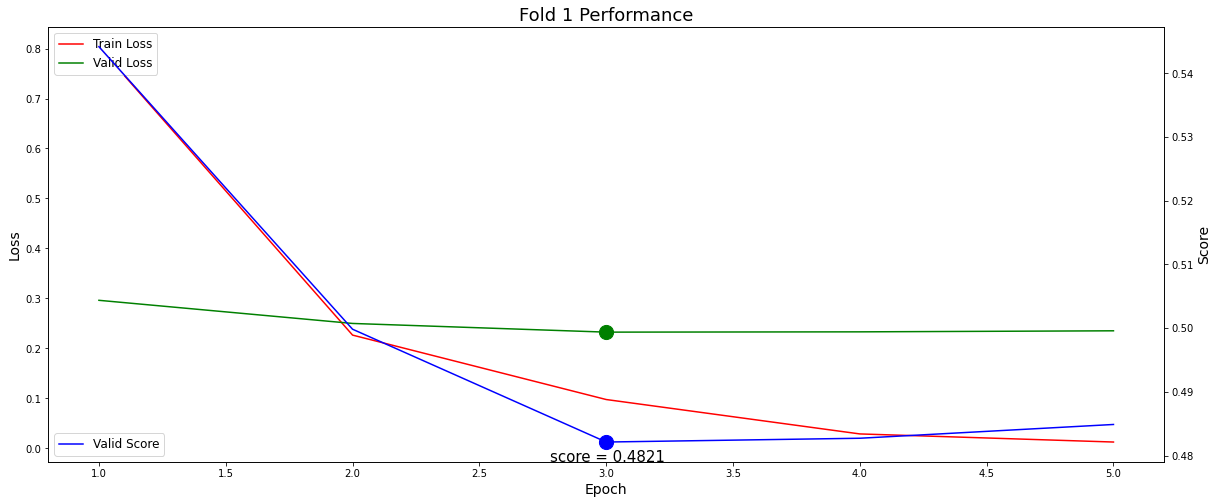

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8900 | val_loss = 0.2990 | val_score = 0.5468 | 5.64 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2091 | val_loss = 0.2498 | val_score = 0.4998 | 4.95 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0699 | val_loss = 0.2330 | val_score = 0.4827 | 4.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0243 | val_loss = 0.2299 | val_score = 0.4795 | 4.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0090 | val_loss = 0.2309 | val_score = 0.4805 | 3.28 min
-------------------------------------------------------
Best: score = 0.4795 (epoch 4)
-------------------------------------------------------


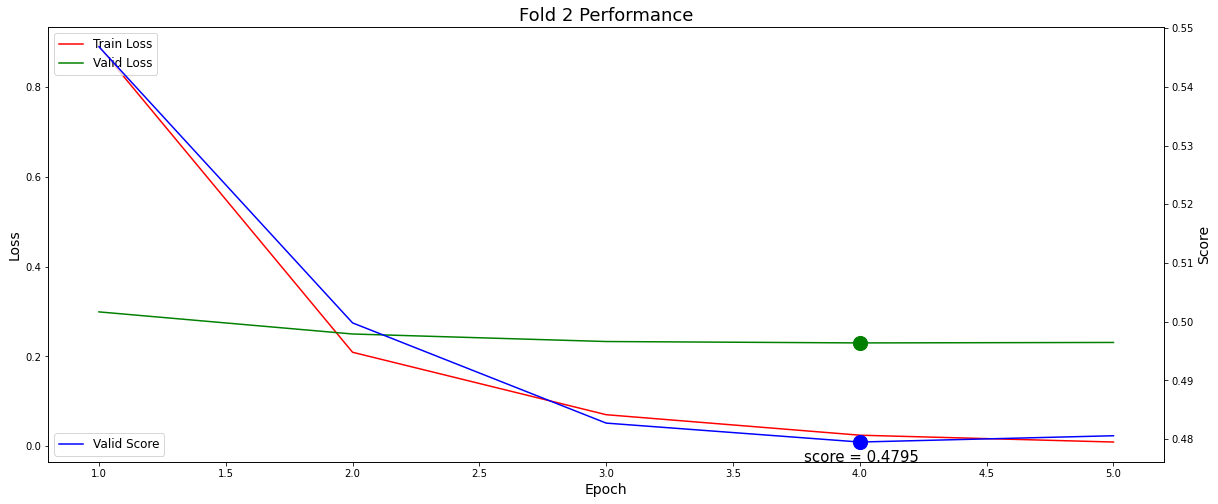

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5515 | val_loss = 0.3213 | val_score = 0.5668 | 5.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2039 | val_loss = 0.2520 | val_score = 0.5020 | 4.72 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0795 | val_loss = 0.2335 | val_score = 0.4832 | 4.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0259 | val_loss = 0.2270 | val_score = 0.4765 | 4.46 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0111 | val_loss = 0.2302 | val_score = 0.4798 | 3.27 min
-------------------------------------------------------
Best: score = 0.4765 (epoch 4)
-------------------------------------------------------


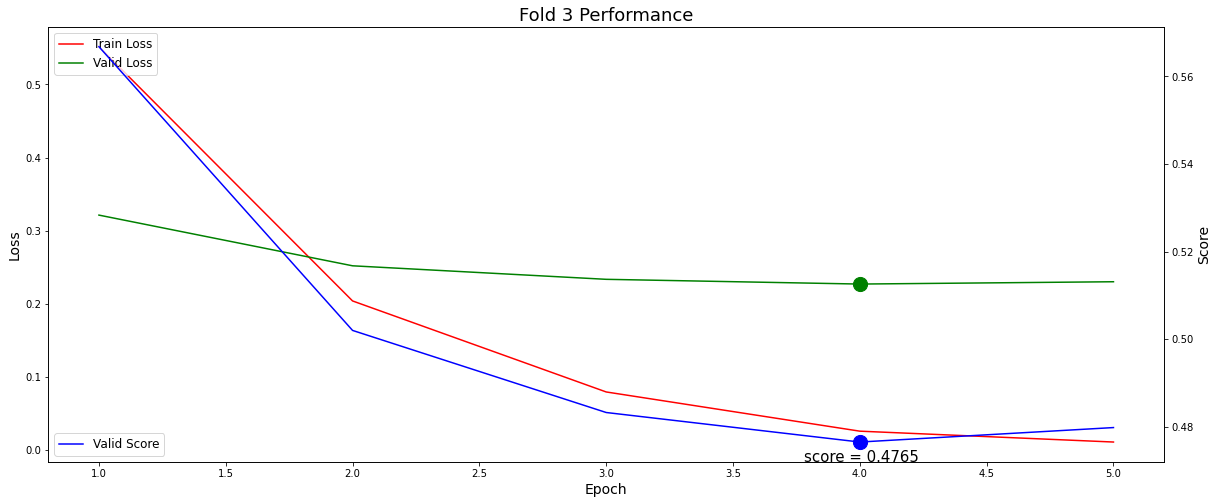

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5985 | val_loss = 0.3246 | val_score = 0.5697 | 5.89 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2370 | val_loss = 0.2545 | val_score = 0.5045 | 4.71 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0885 | val_loss = 0.2353 | val_score = 0.4851 | 4.47 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0296 | val_loss = 0.2333 | val_score = 0.4830 | 3.74 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0119 | val_loss = 0.2345 | val_score = 0.4842 | 3.26 min
-------------------------------------------------------
Best: score = 0.4830 (epoch 4)
-------------------------------------------------------


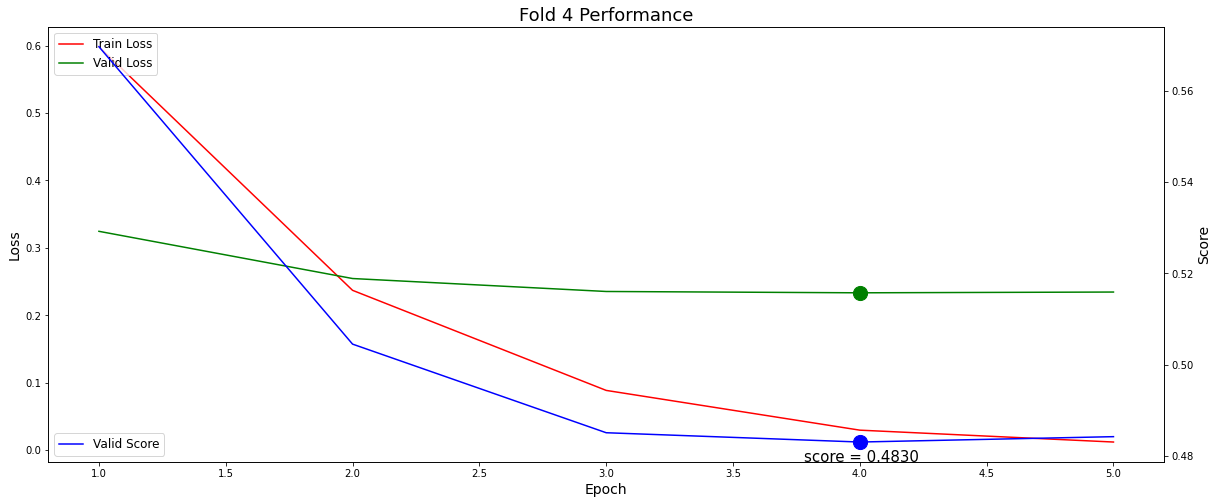

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5964 | val_loss = 0.2955 | val_score = 0.5436 | 5.16 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2510 | val_loss = 0.2500 | val_score = 0.5000 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0973 | val_loss = 0.2337 | val_score = 0.4834 | 3.97 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0361 | val_loss = 0.2271 | val_score = 0.4765 | 3.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0137 | val_loss = 0.2291 | val_score = 0.4787 | 3.26 min
-------------------------------------------------------
Best: score = 0.4765 (epoch 4)
-------------------------------------------------------


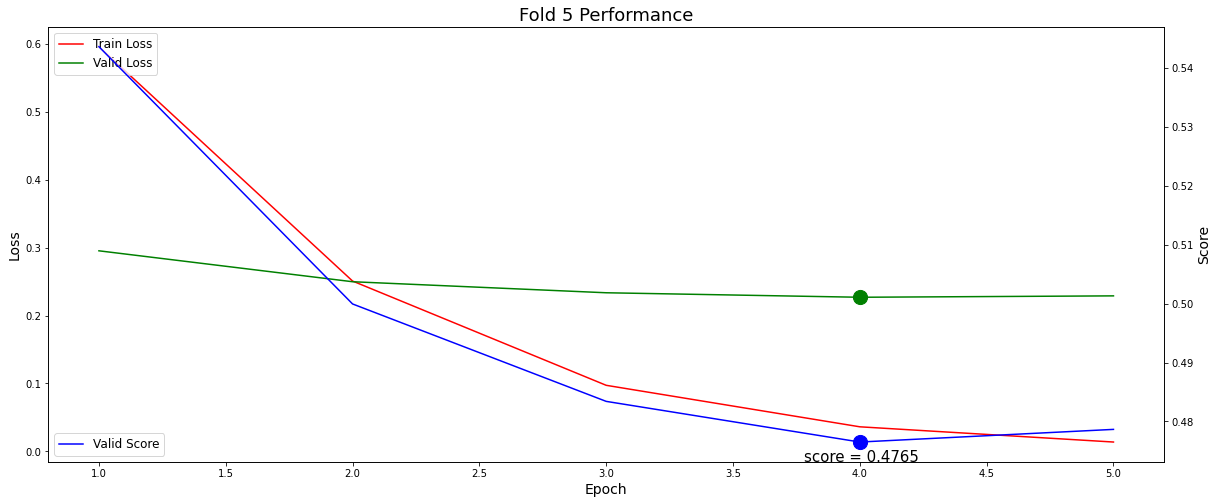

-------------------------------------------------------
REP 2/3 | OOF score = 0.4795
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7679 | val_loss = 0.3128 | val_score = 0.5593 | 5.89 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2207 | val_loss = 0.2496 | val_score = 0.4996 | 4.47 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0896 | val_loss = 0.2220 | val_score = 0.4712 | 5.44 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0299 | val_loss = 0.2210 | val_score = 0.4701 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0121 | val_loss = 0.2226 | val_score = 0.4718 | 3.27 min
-------------------------------------------------------
Best: score = 0.4701 (epoch 4)
-------------------------------------------------------


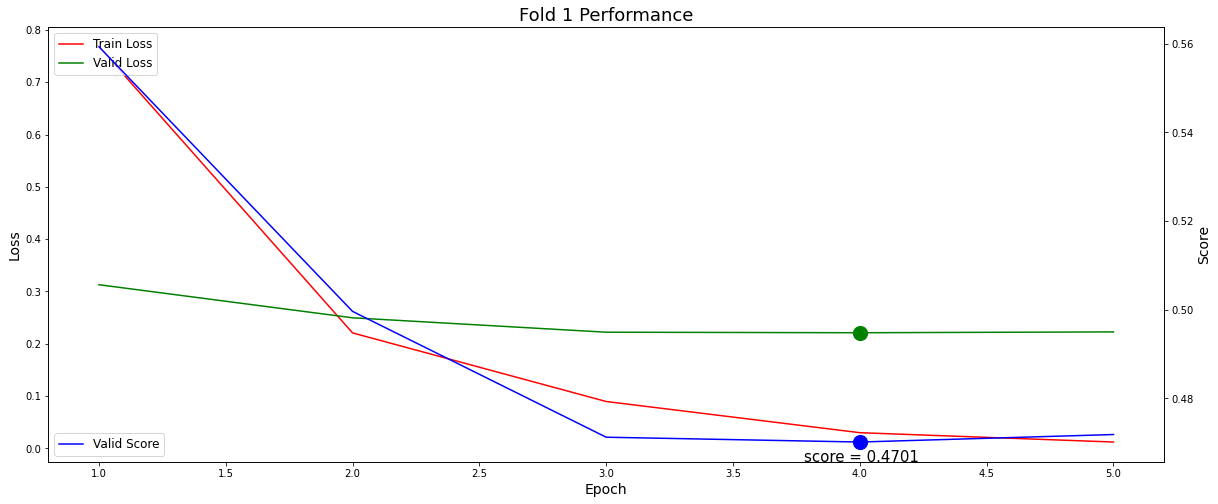

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8352 | val_loss = 0.2910 | val_score = 0.5395 | 7.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2530 | val_loss = 0.2401 | val_score = 0.4900 | 5.43 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0916 | val_loss = 0.2195 | val_score = 0.4685 | 3.98 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0376 | val_loss = 0.2153 | val_score = 0.4640 | 4.23 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0153 | val_loss = 0.2159 | val_score = 0.4646 | 3.27 min
-------------------------------------------------------
Best: score = 0.4640 (epoch 4)
-------------------------------------------------------


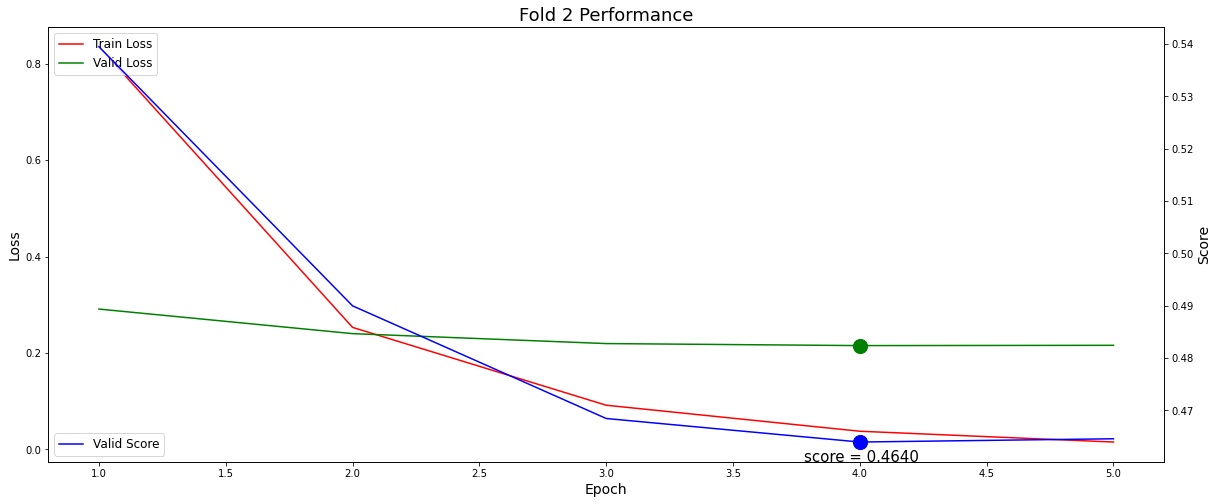

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5606 | val_loss = 0.2798 | val_score = 0.5290 | 5.41 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2469 | val_loss = 0.2340 | val_score = 0.4838 | 4.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0879 | val_loss = 0.2250 | val_score = 0.4744 | 4.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0277 | val_loss = 0.2246 | val_score = 0.4739 | 3.51 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0116 | val_loss = 0.2297 | val_score = 0.4793 | 3.27 min
-------------------------------------------------------
Best: score = 0.4739 (epoch 4)
-------------------------------------------------------


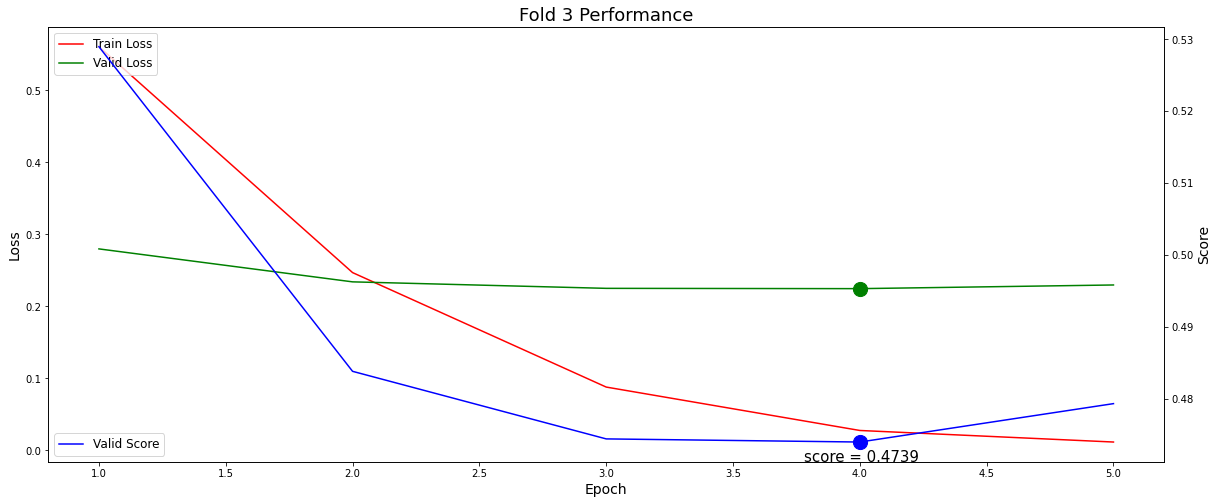

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6238 | val_loss = 0.3204 | val_score = 0.5660 | 4.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2538 | val_loss = 0.2376 | val_score = 0.4874 | 4.49 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0874 | val_loss = 0.2296 | val_score = 0.4792 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0276 | val_loss = 0.2258 | val_score = 0.4752 | 3.76 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0103 | val_loss = 0.2283 | val_score = 0.4778 | 3.27 min
-------------------------------------------------------
Best: score = 0.4752 (epoch 4)
-------------------------------------------------------


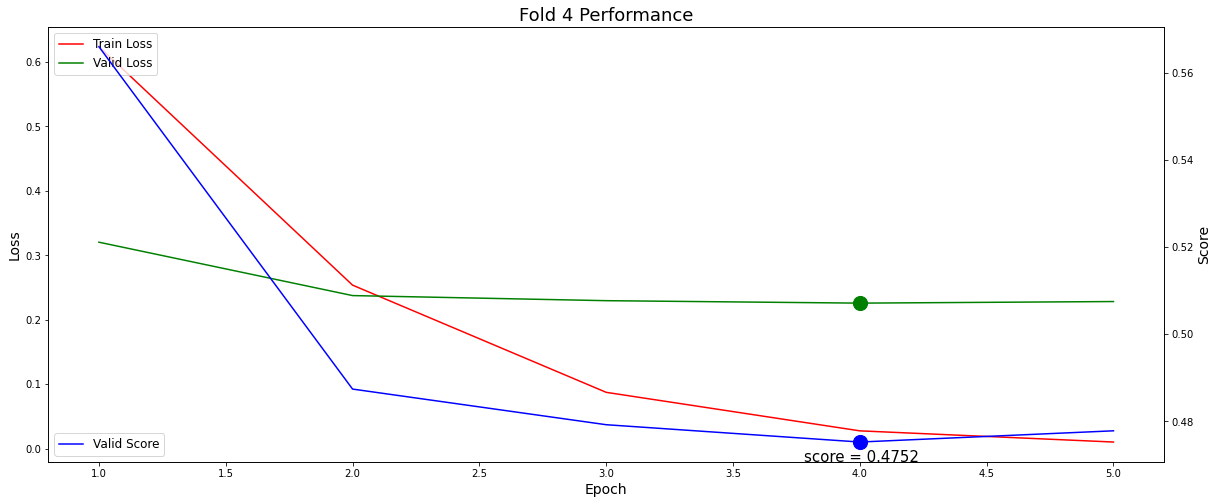

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6034 | val_loss = 0.3285 | val_score = 0.5731 | 5.18 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2411 | val_loss = 0.2582 | val_score = 0.5081 | 4.73 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.0851 | val_loss = 0.2406 | val_score = 0.4905 | 3.99 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0281 | val_loss = 0.2401 | val_score = 0.4900 | 3.51 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0119 | val_loss = 0.2414 | val_score = 0.4914 | 3.27 min
-------------------------------------------------------
Best: score = 0.4900 (epoch 4)
-------------------------------------------------------


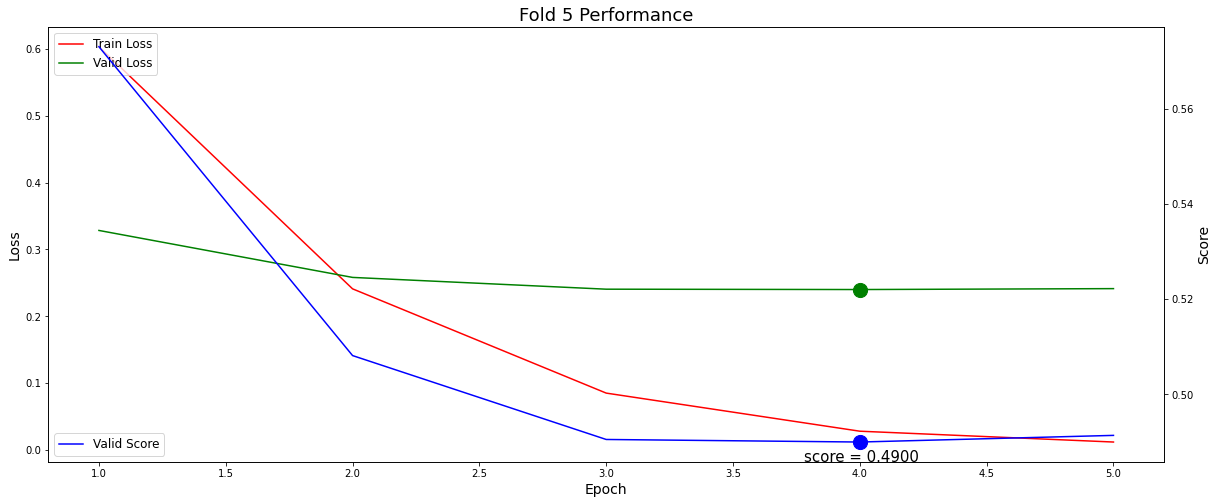

-------------------------------------------------------
REP 3/3 | OOF score = 0.4746
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4791
-------------------------------------------------------

Finished in 325.17 minutes


In [12]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [13]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-- loaded custom weights


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 10.59 minutes


In [14]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4792
OOF bag score = 0.4716
----------------------


In [15]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()